<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
#residential houses
residential = ['FV','RH','RL','RP','RM']
#filter residential houses
house = house[house.MSZoning.isin(residential)]

In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-n

In [5]:
# check mean and median value of LotFrontage,
# if they are similiar, then I can impute the NaN
# values with either median and mean

print(house.LotFrontage.median())
print(house.LotFrontage.mean())

70.0
70.0528967254408


In [6]:
#impute LotFrontage NaN values with 
# median of LotFrontage

house.LotFrontage.fillna(house.LotFrontage.median(),inplace=True)

#fill Nan values with 'NA' string
house.Alley.fillna('NA',inplace=True)

In [7]:
# look at NaN fields in MasVnrType and MasVnrArea
house[house.MasVnrType.isnull()].loc[:,'Exterior1st':'Foundation']

,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation
234,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc
529,Wd Sdng,Stone,NaN,NaN,Gd,TA,PConc
650,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc
936,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc
973,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc
977,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc
1243,VinylSd,VinylSd,NaN,NaN,Ex,TA,PConc
1278,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc


In [8]:
#fill MasVnrType NaN values with 'None'
house.MasVnrType.fillna('None',inplace=True)

#fill MasVnrArea NaN values with 0
house.MasVnrArea.fillna(0,inplace=True)

#since the basement related quality and ratings are 
# NaN for houses with no basement, 
# I changed the NaN values to 'NA' string
house.loc[:,'BsmtQual':'BsmtFinType2'] = house.loc[:,
                    'BsmtQual':'BsmtFinType2'].apply(lambda x: x.fillna('NA'))

In [9]:
#check values of Electrical
house.Electrical.value_counts(dropna=False)

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64

In [10]:
# since there is only 1 NaN value, I replaced it with the highest count,
#which is SBrkr
house.Electrical.fillna('SBrkr',inplace=True)

In [11]:
#check number of counts of houses with 0 fireplace
house[house.FireplaceQu.isnull()].loc[:,'Fireplaces'].value_counts()

0    681
Name: Fireplaces, dtype: int64

In [12]:
#check that number tallies with number of NaN values for FireplaceQu
house[house.FireplaceQu.isnull()].loc[:,'FireplaceQu'].value_counts(dropna=False)

NaN    681
Name: FireplaceQu, dtype: int64

In [13]:
#since FireplaceQu is NaN for houses with 0 fireplace, I will replace the NaN 
# with 'NA'
house.FireplaceQu.fillna('NA',inplace=True)

In [14]:
#check garage-related data for NaN values are the same
# if they are the same, it means that the houses do not have a garage
house.loc[:,'GarageType':'GarageCond'].isnull().sum()

GarageType      79
GarageYrBlt     79
GarageFinish    79
GarageCars       0
GarageArea       0
GarageQual      79
GarageCond      79
dtype: int64

In [15]:
#since the garage-related quality and conditions are NaN for houses with no
# garage, I changed the NaN values to 'NA' string

#I did not change the GarageYrBuilt NaN values, since the variable is 
# already a float

house.loc[:,['GarageType','GarageFinish','GarageQual','GarageCond']] = \
house.loc[:,['GarageType','GarageFinish','GarageQual','GarageCond']].apply(lambda x: x.fillna('NA'))

In [16]:
#changed misc NaN values to 'NA'

house.loc[:,'PoolArea':'MiscFeature'] = \
house.loc[:,'PoolArea':'MiscFeature'].apply(lambda x: x.fillna('NA'))

## Feature Engineering

In [17]:
# create a dummy variable to check whether house was
#recently built/remodelled(ie 2000 or later), 
# 1 if Yes, and 0 if no

house['is_recent_remod']=(house.YearRemodAdd>=2000).astype('int')

## Define Fixed and Renovatable Features

In [18]:
#define fixed and renovatable attributes

fixed = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street',
         'Alley','LotShape','LandContour','LotConfig','LandSlope',
         'Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
         'MasVnrArea','Foundation','BsmtQual','BsmtExposure','BsmtFinSF1',
         'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
         'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath',
         'HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces',
         'GarageType','GarageCars','GarageArea','PavedDrive','WoodDeckSF',
         'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
         'MiscFeature','MiscVal','is_recent_remod'
]

renov = ['Utilities','OverallQual','OverallCond','RoofStyle','RoofMatl',
         'Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond',
         'BsmtCond','BsmtFinType1','BsmtFinType2','Heating','HeatingQC',
         'CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
         'GarageFinish','GarageQual','GarageCond','PoolQC','Fence'
]


y = house[house.YrSold<2010]['SalePrice']
y_holdout = house[house.YrSold==2010]['SalePrice']

X_fixed = house[fixed]

In [19]:
fixed_categorical = []
fixed_numeric = []

for column in house[fixed].columns:
    if column == 'MSSubClass' :
        fixed_categorical.append(column)
    elif column == 'is_recent_remod' :
        fixed_categorical.append(column)    
    elif house[column].dtypes=='object':
        fixed_categorical.append(column)
    else:
        fixed_numeric.append(column)
        
print(fixed_categorical)
print('-'*30)
print(fixed_numeric)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'Foundation', 'BsmtQual', 'BsmtExposure', 'GarageType', 'PavedDrive', 'MiscFeature', 'is_recent_remod']
------------------------------
['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


## Feature Selection

C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


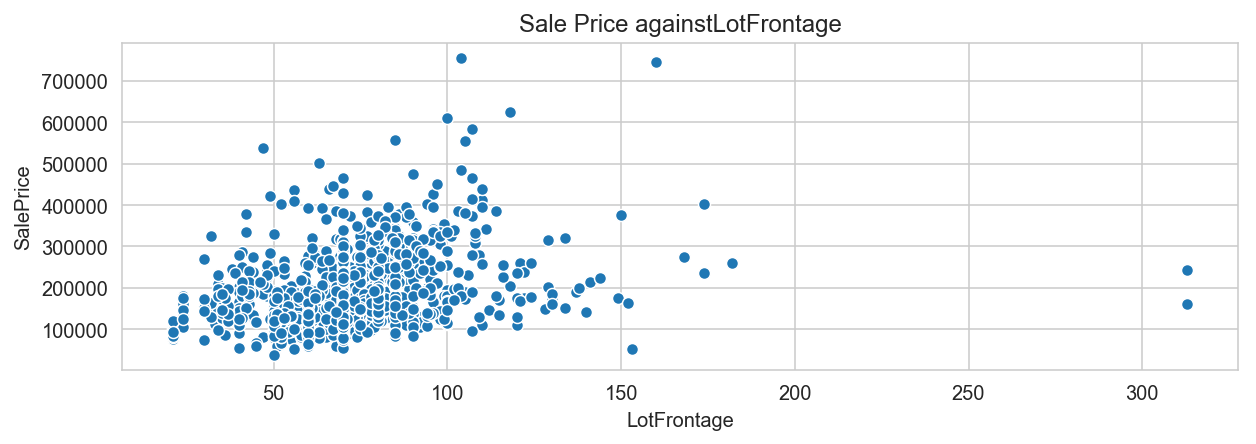

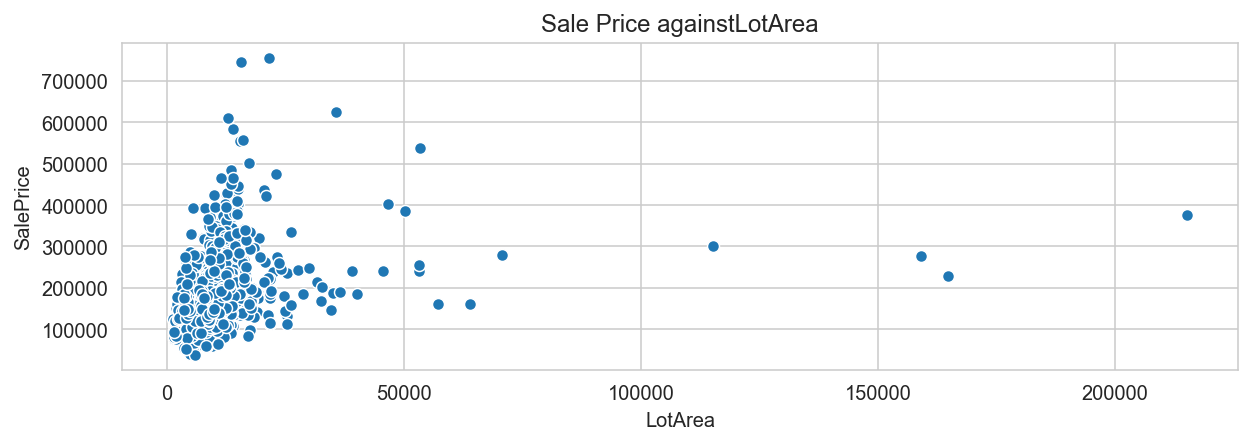

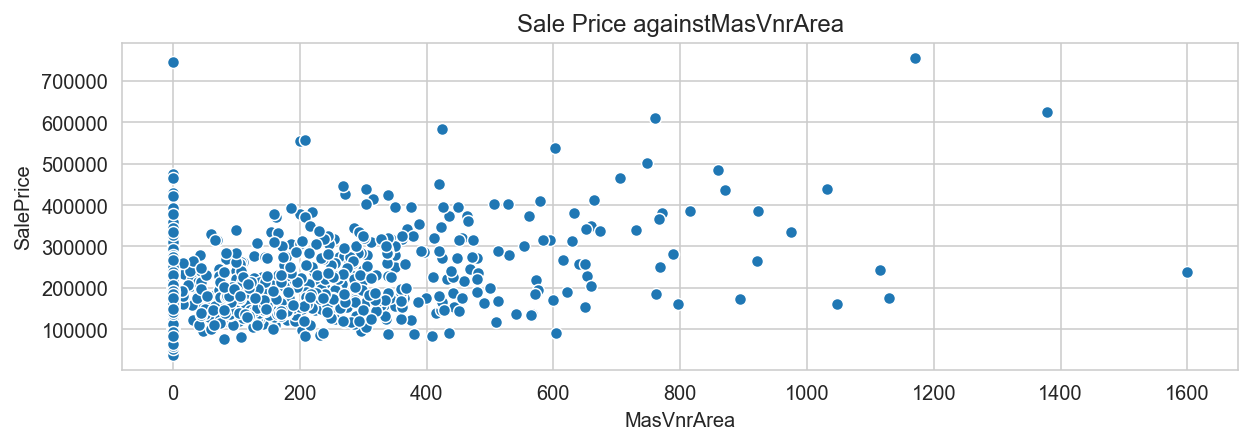

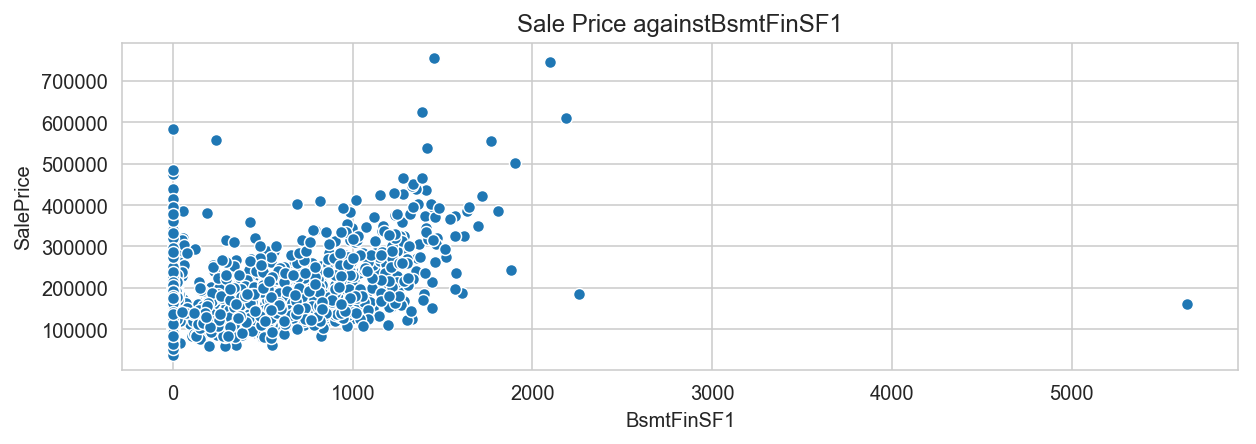

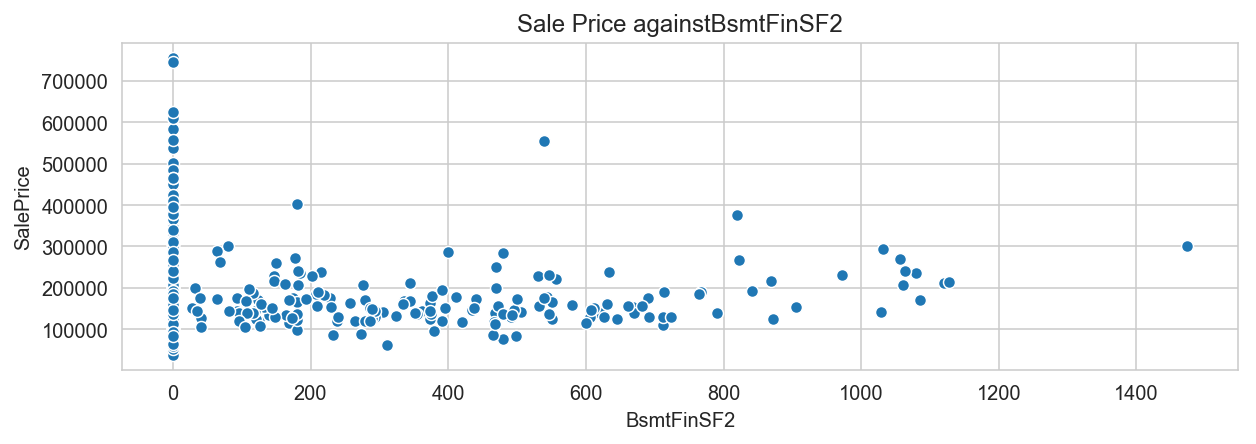

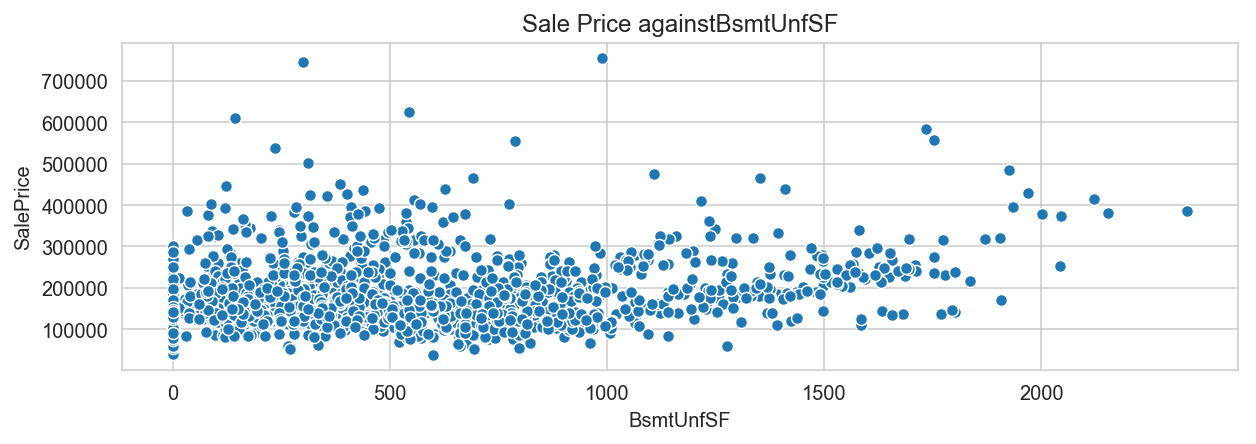

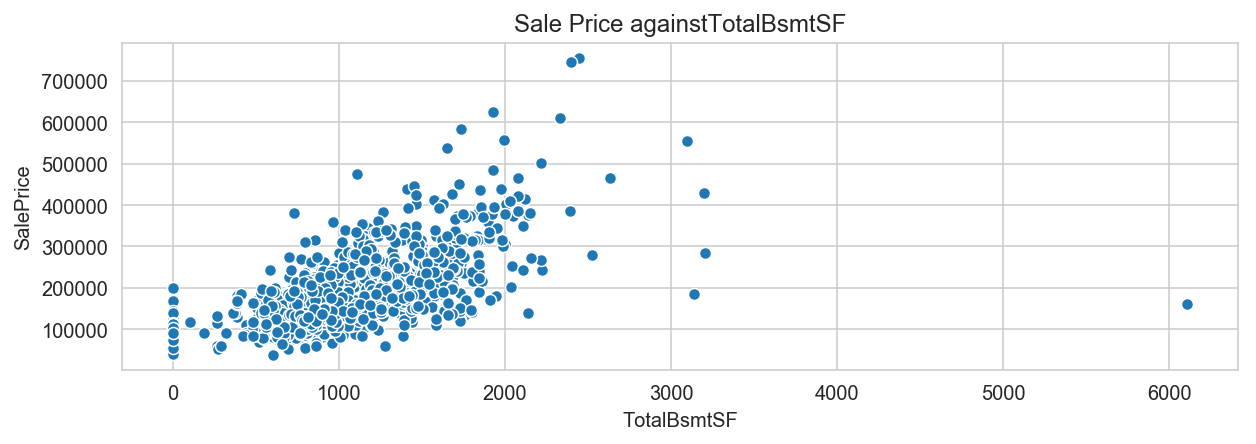

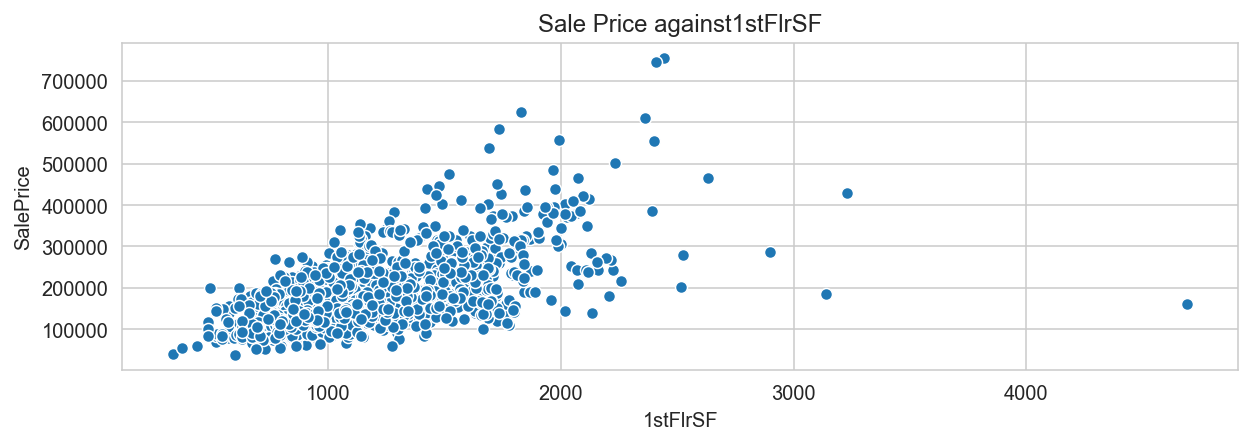

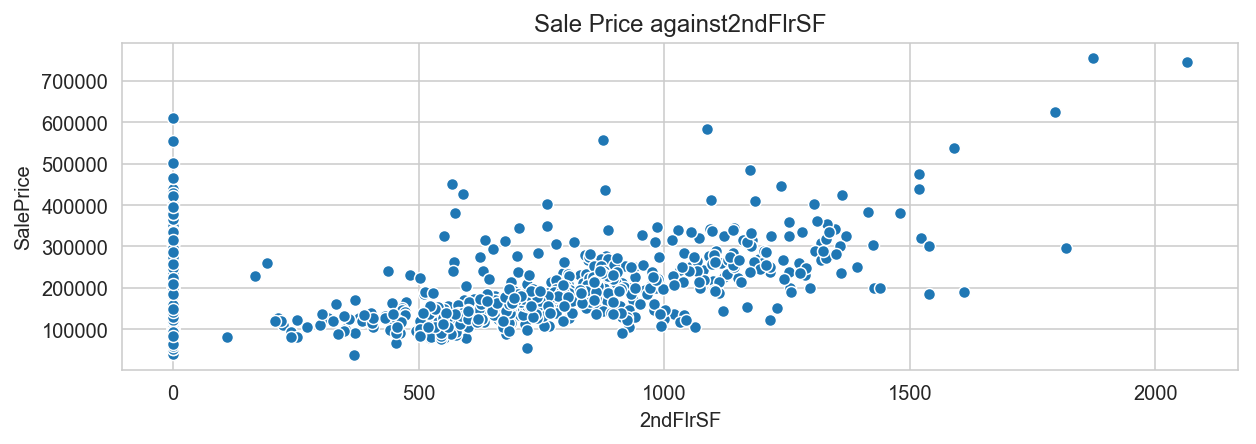

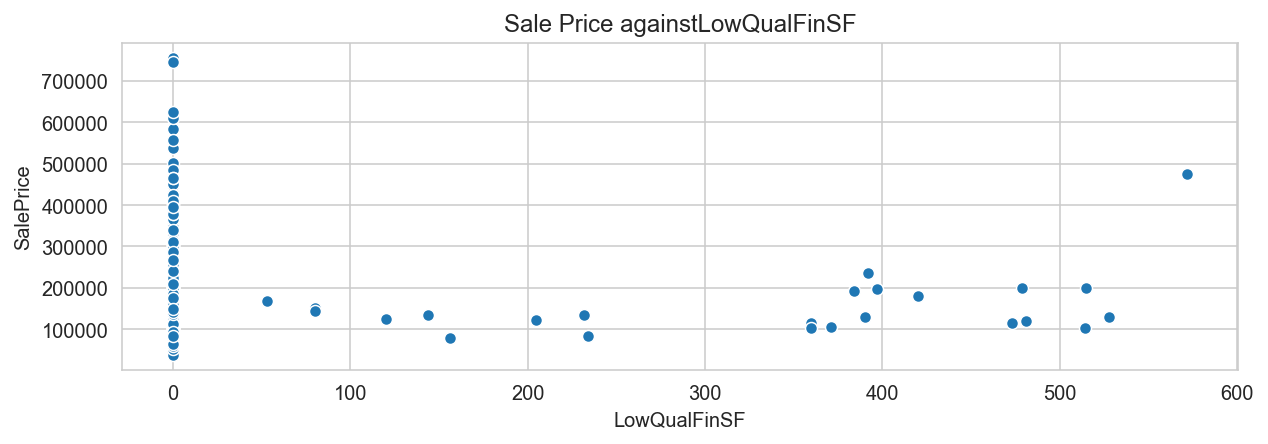

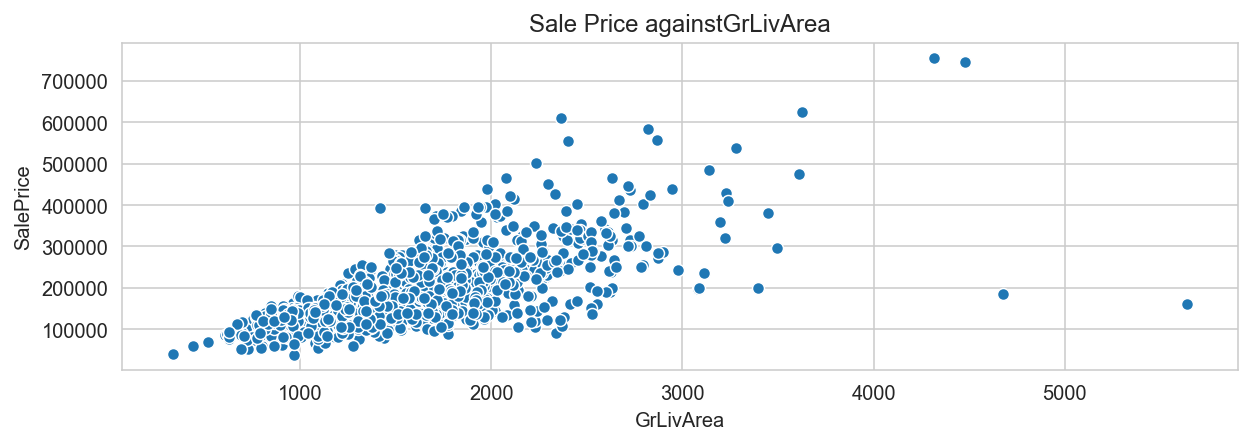

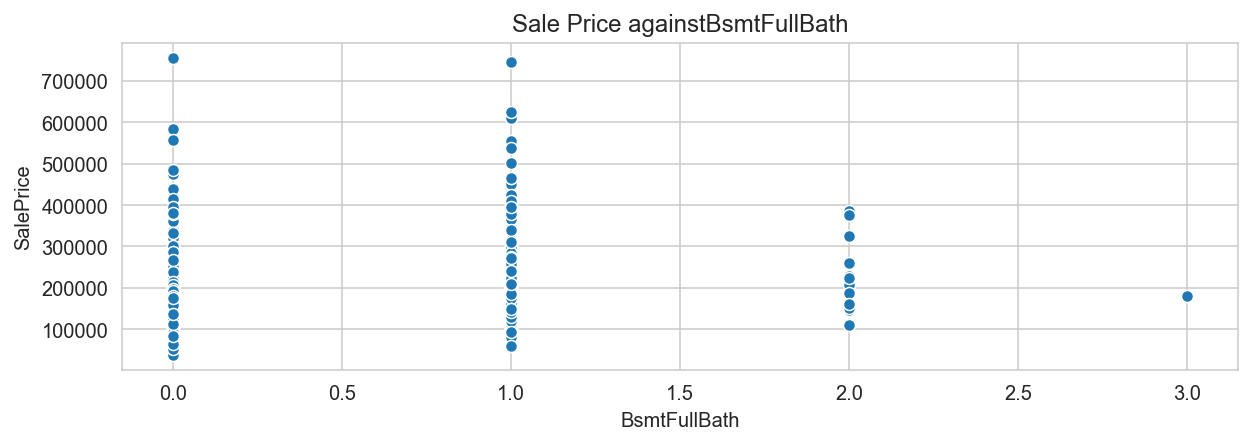

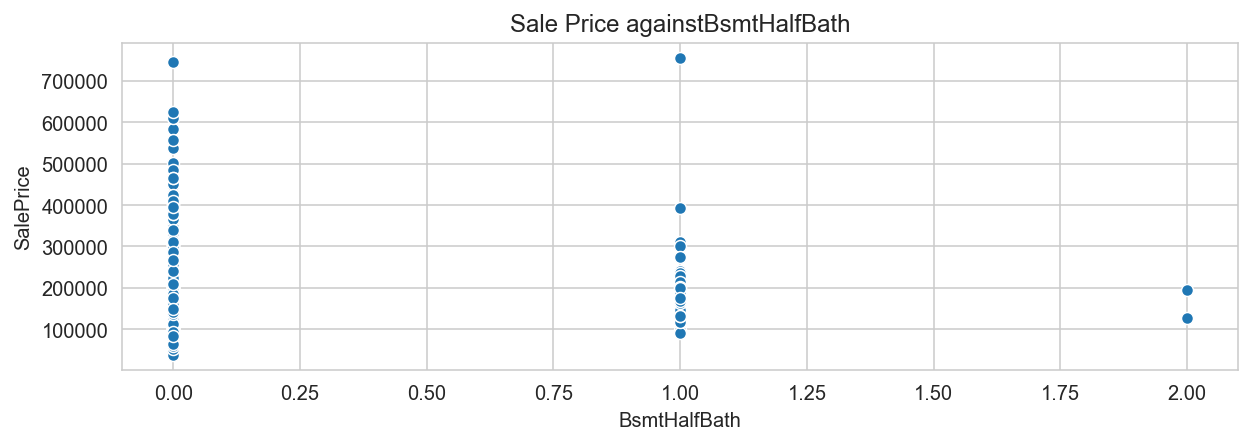

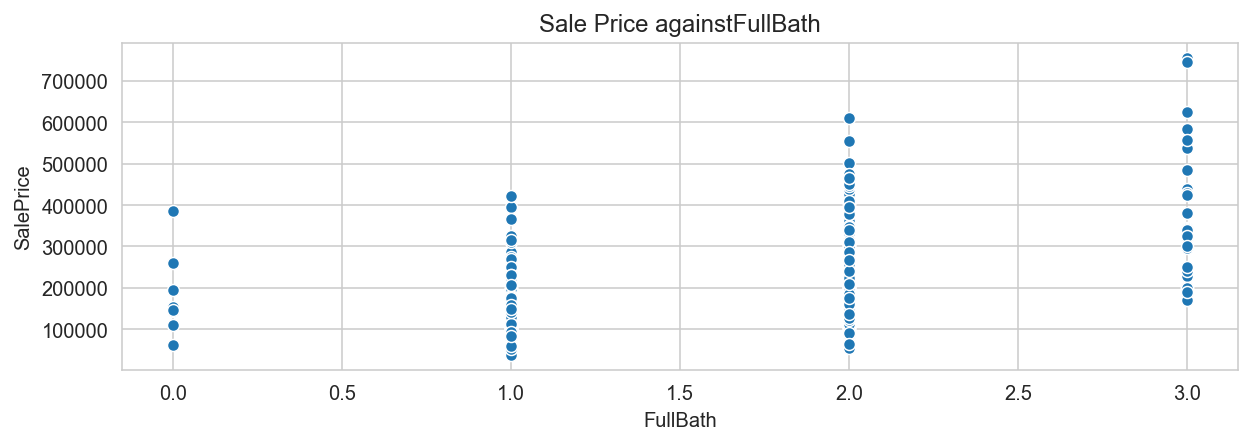

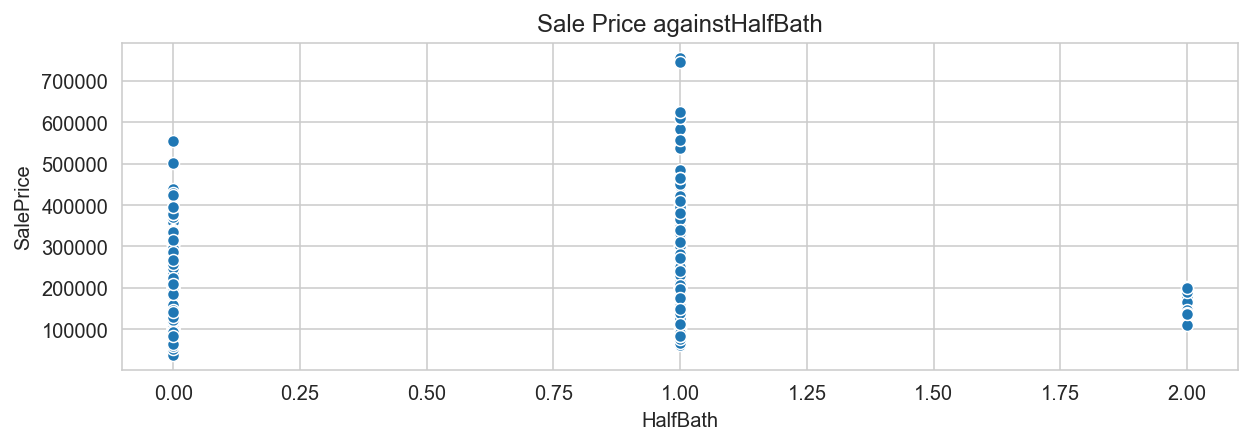

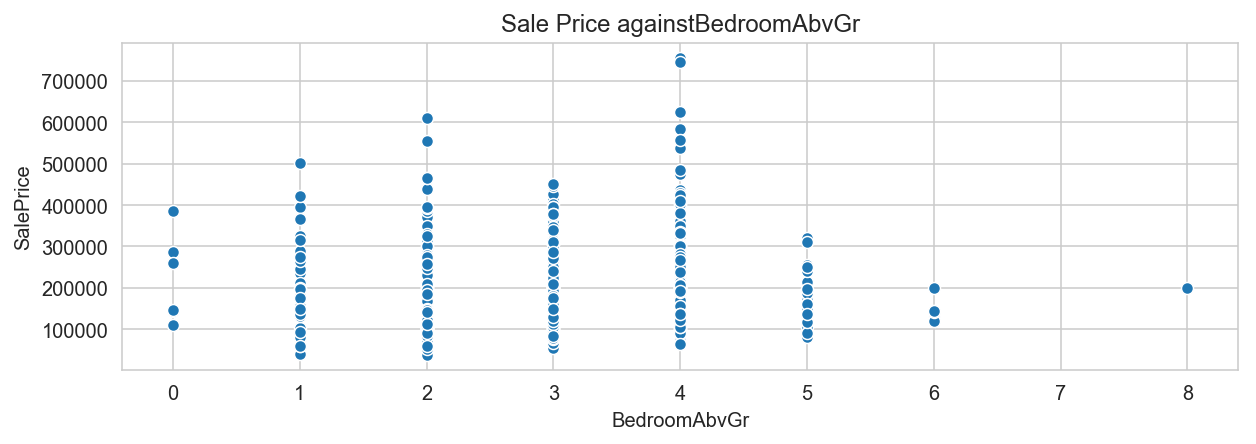

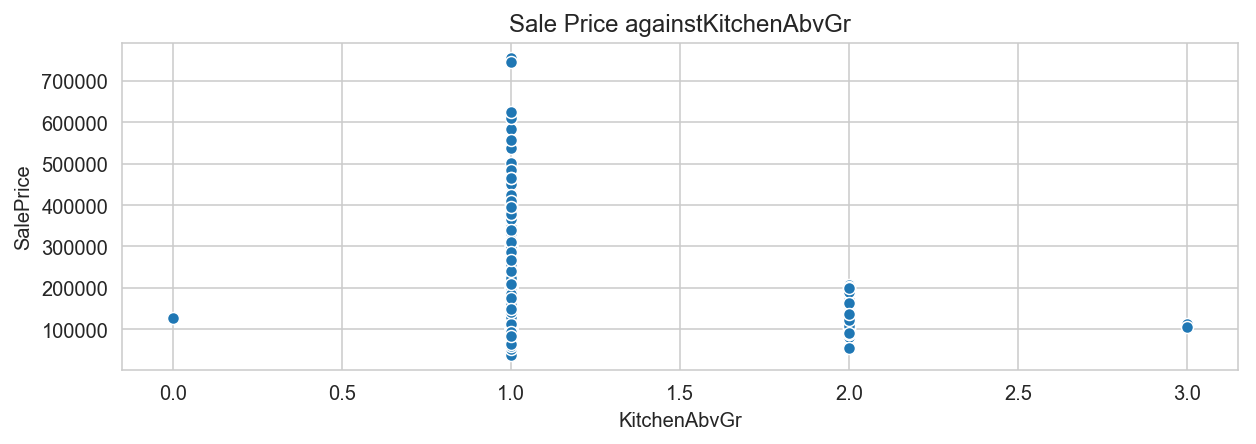

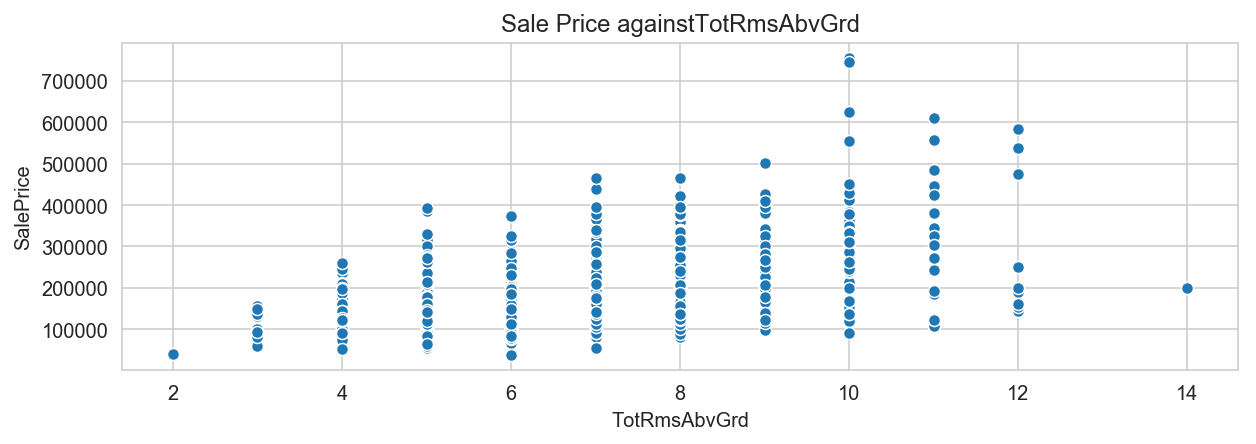

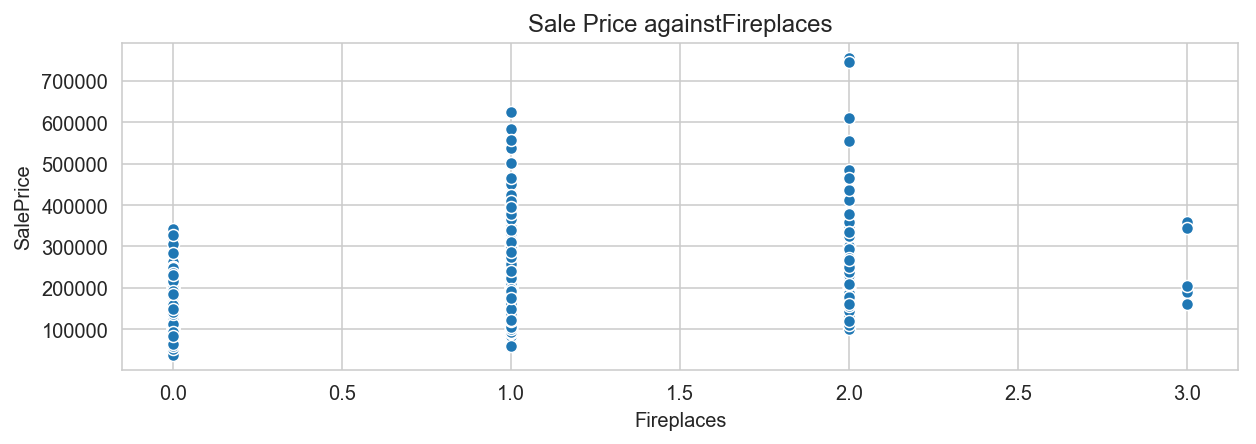

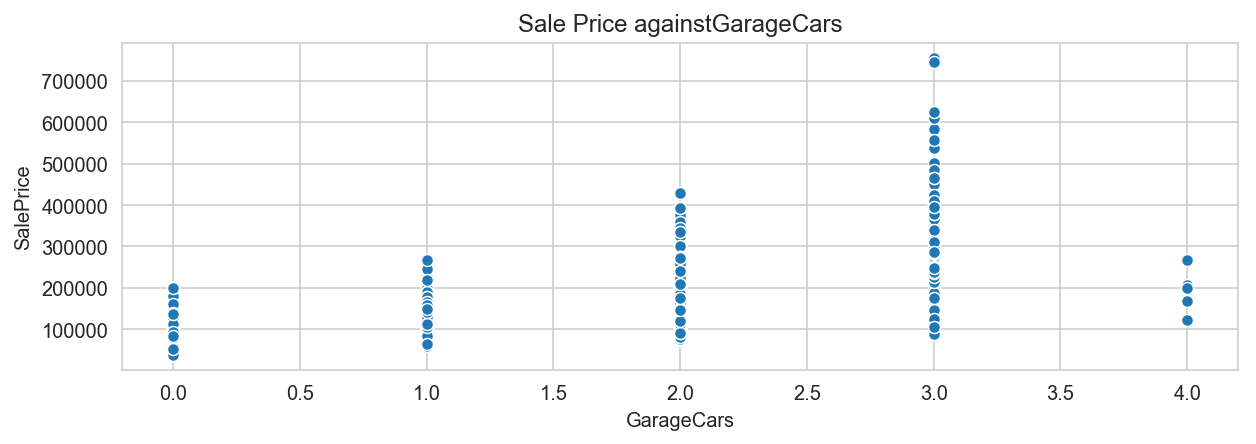

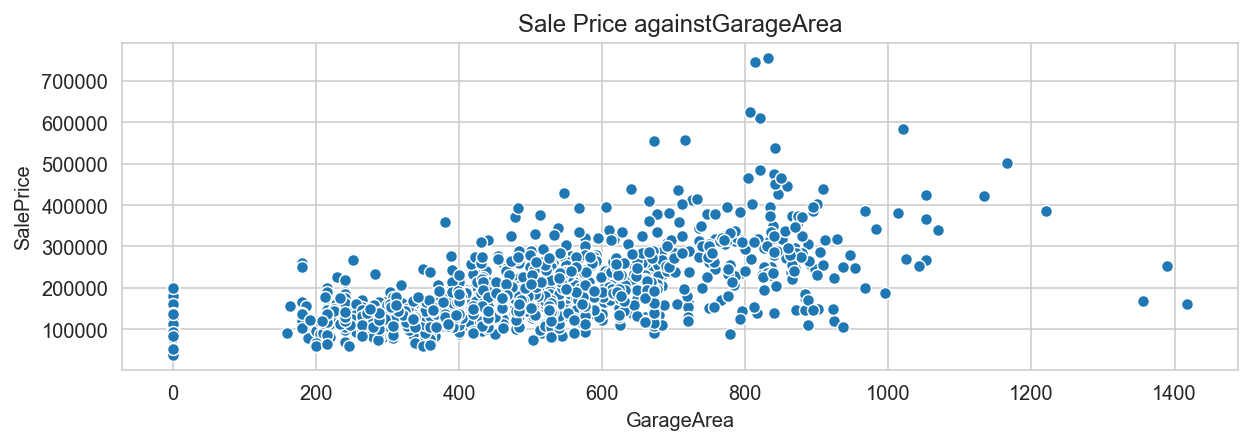

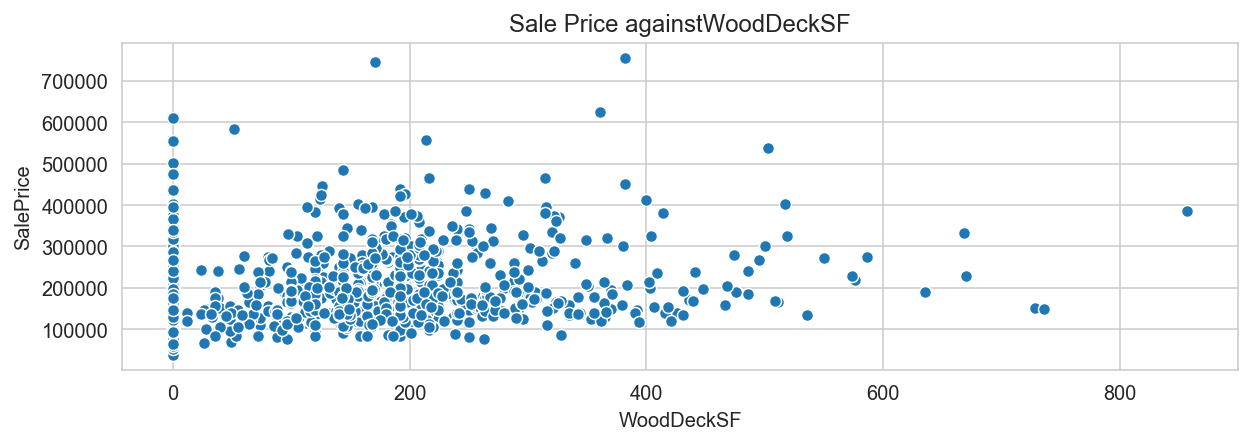

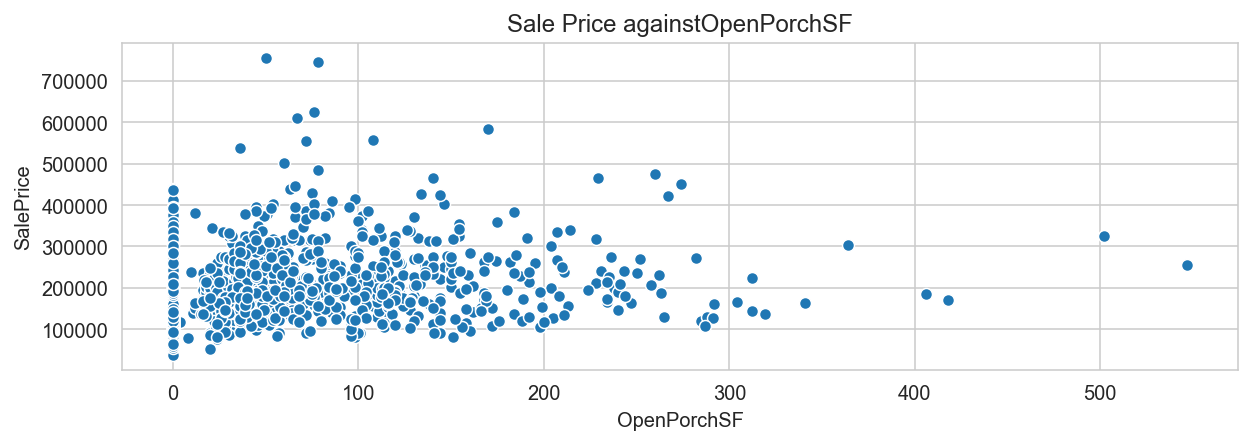

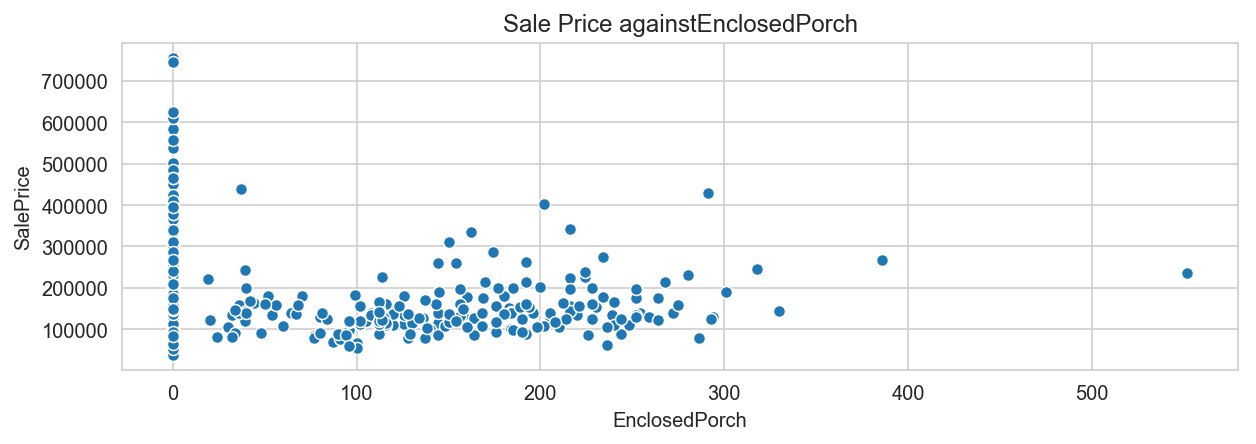

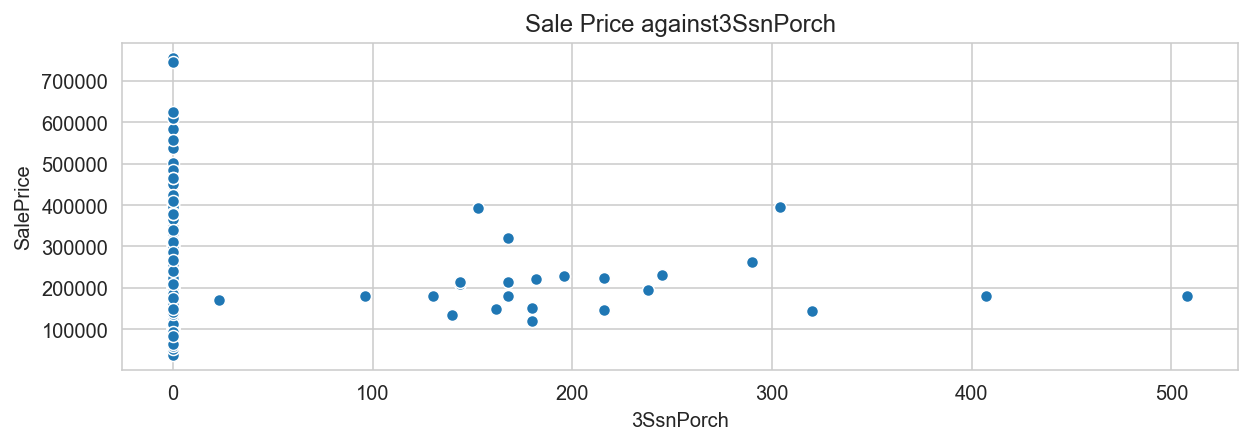

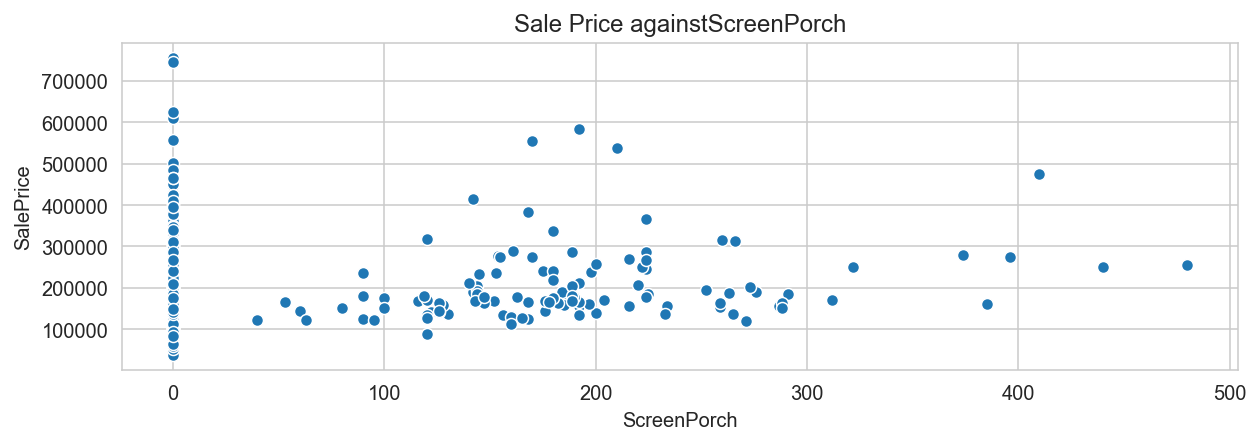

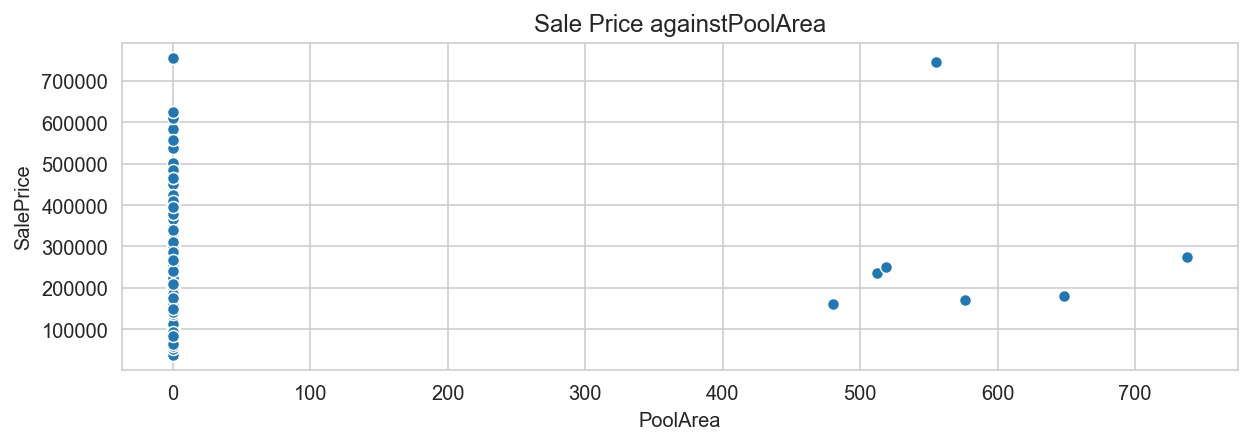

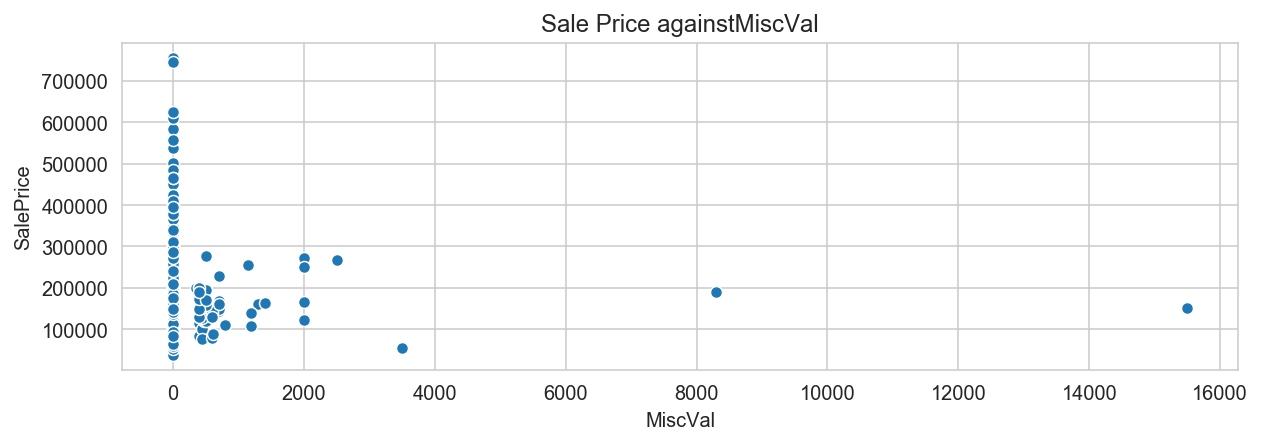

In [20]:
for col in fixed_numeric:
    plt.figure(col,figsize=(10,3))
    sns.scatterplot(y='SalePrice',x=col,data=house)
    plt.title('Sale Price against'+col)

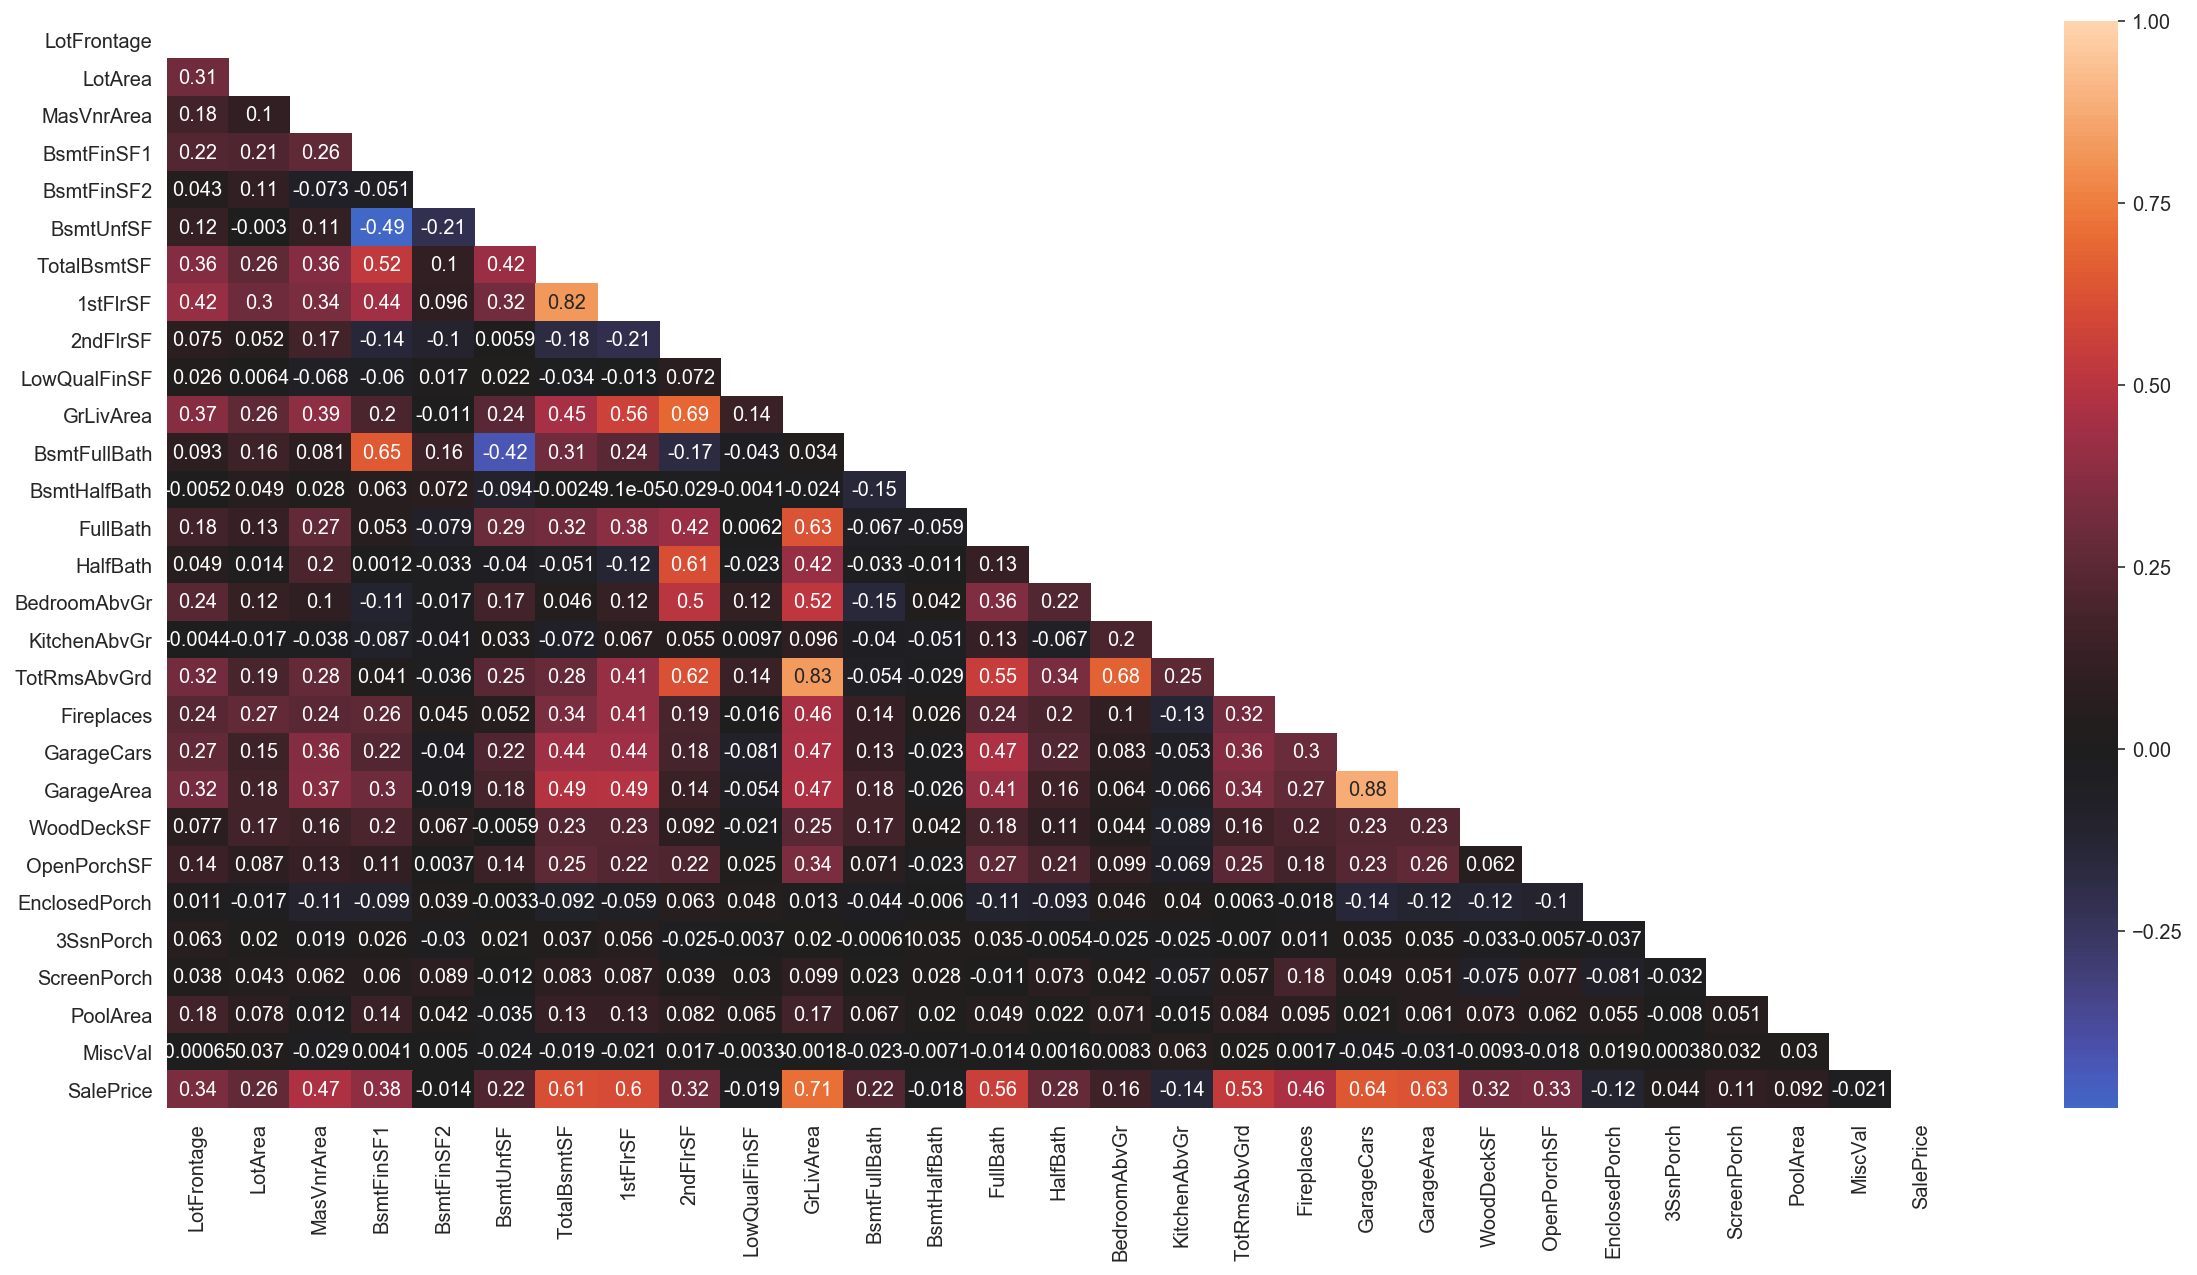

In [21]:
#check correlation of fixed numeric variables
plt.figure(figsize=(20,10))
corr = pd.concat([house[fixed_numeric],house['SalePrice']],axis=1).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,center=0,annot=True,mask=mask);

By looking at the heatmap, those variables which are mildly correlated (>0.5) with SalePrice have some high correlation with other variables. 

To avoid multicollinearity, I chose the following numeric variables for feature selection:
1. 1stFlrSF
2. GrLivArea
3. FullBath
4. GarageArea

C:\Users\hp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


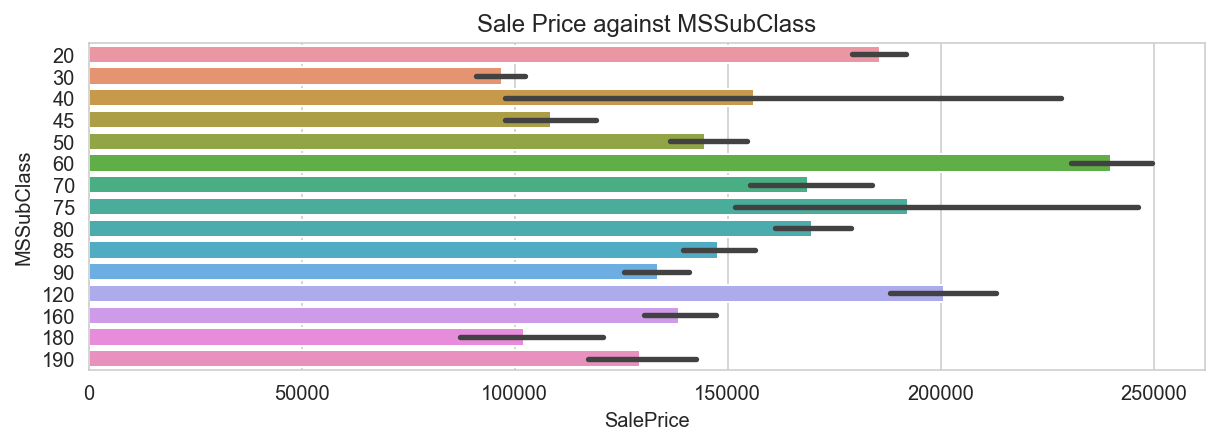

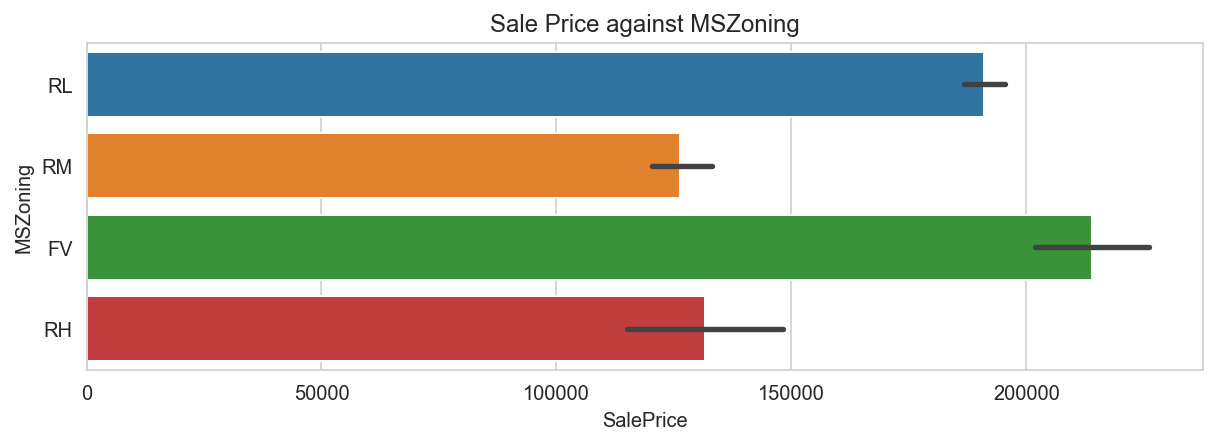

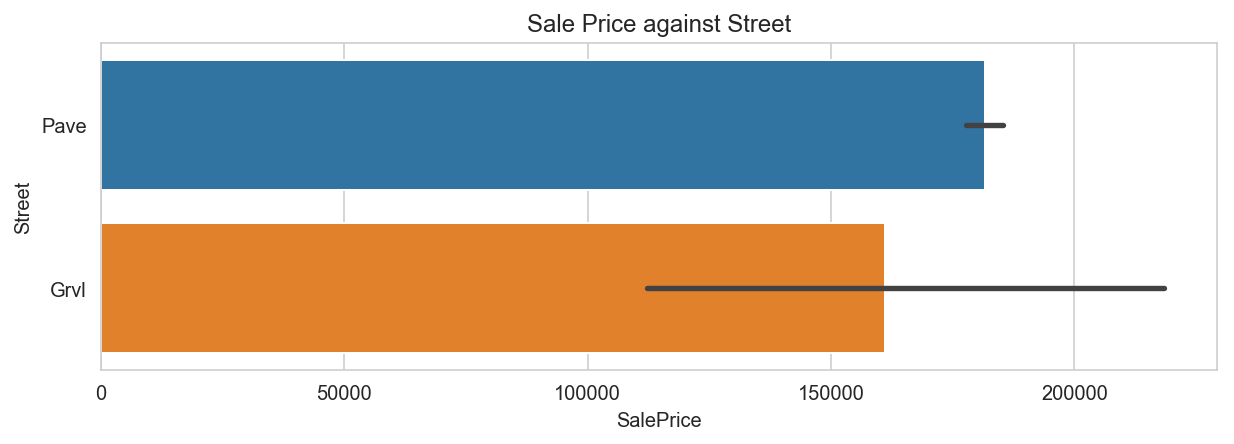

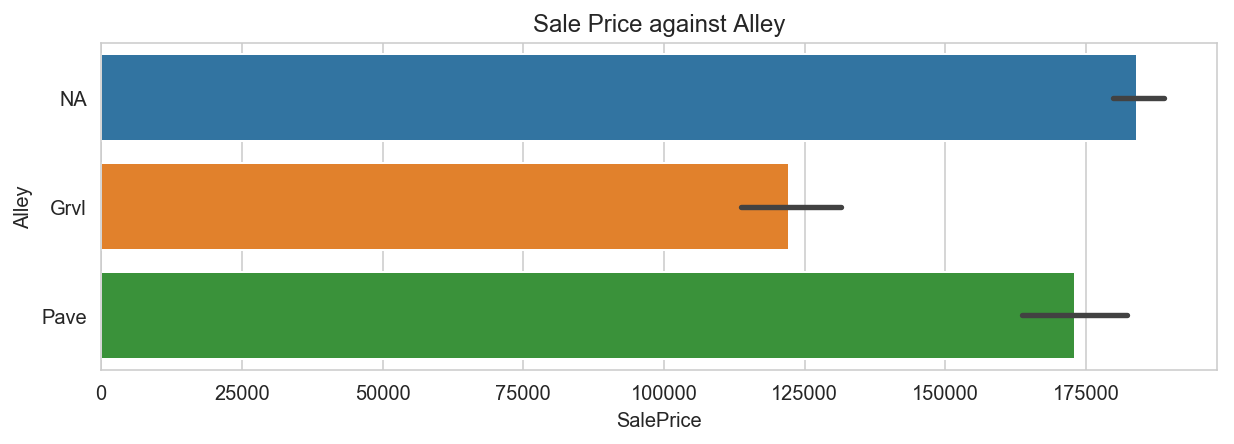

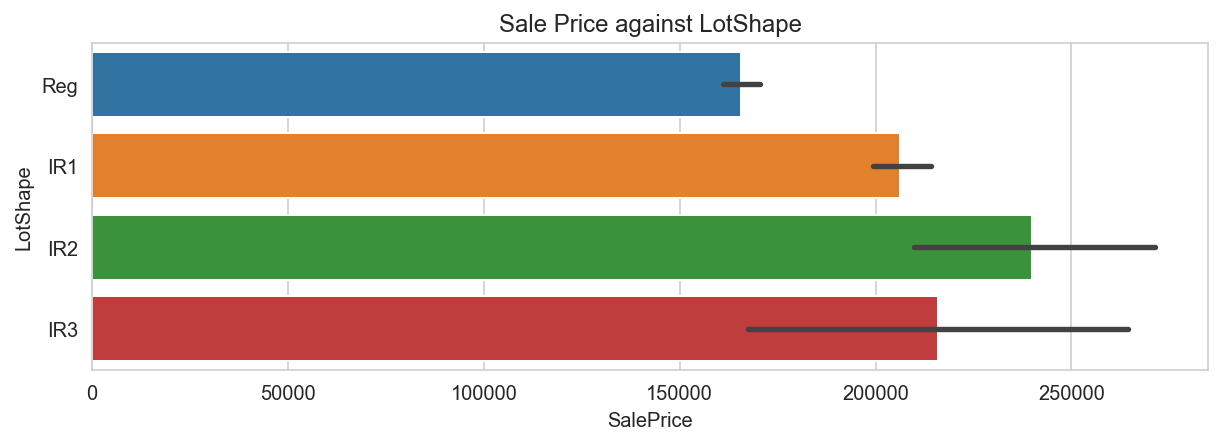

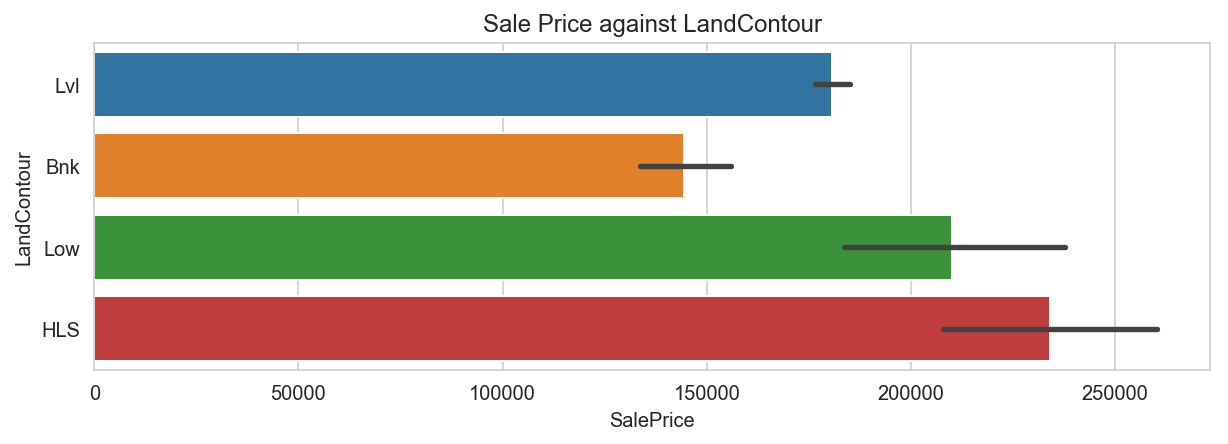

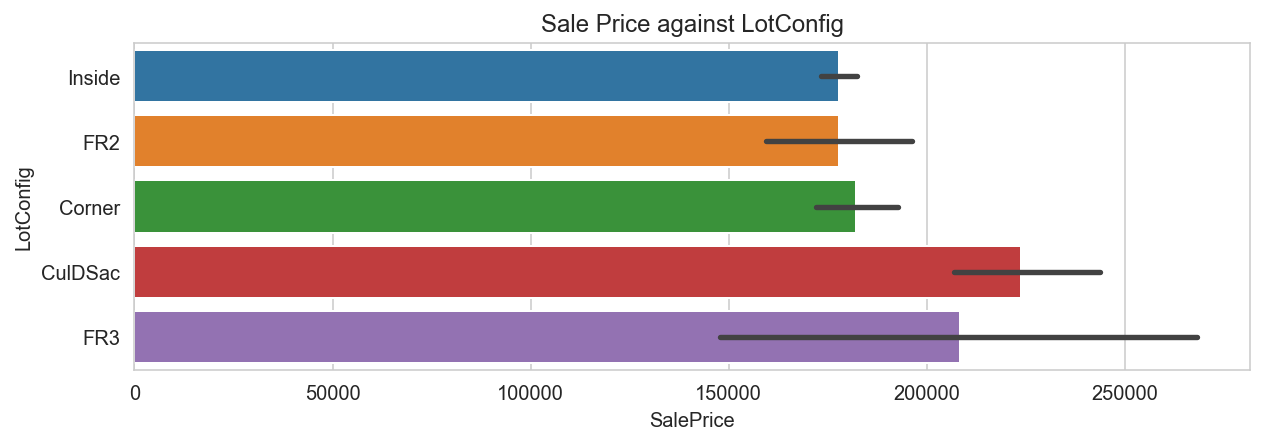

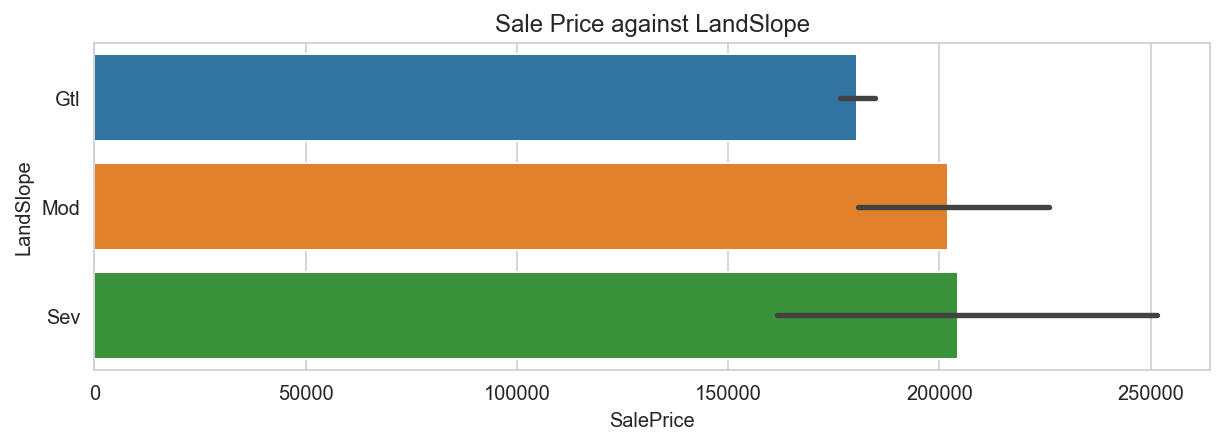

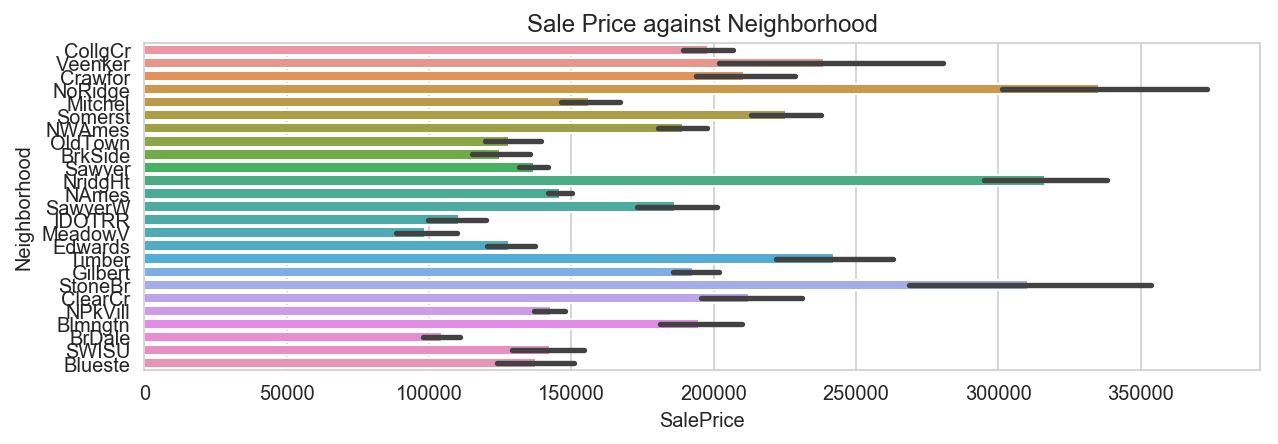

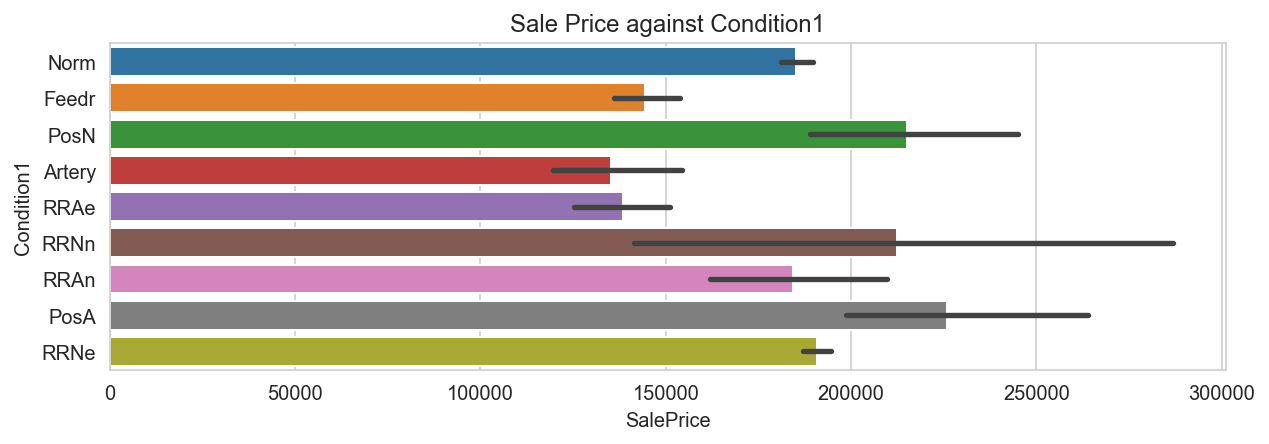

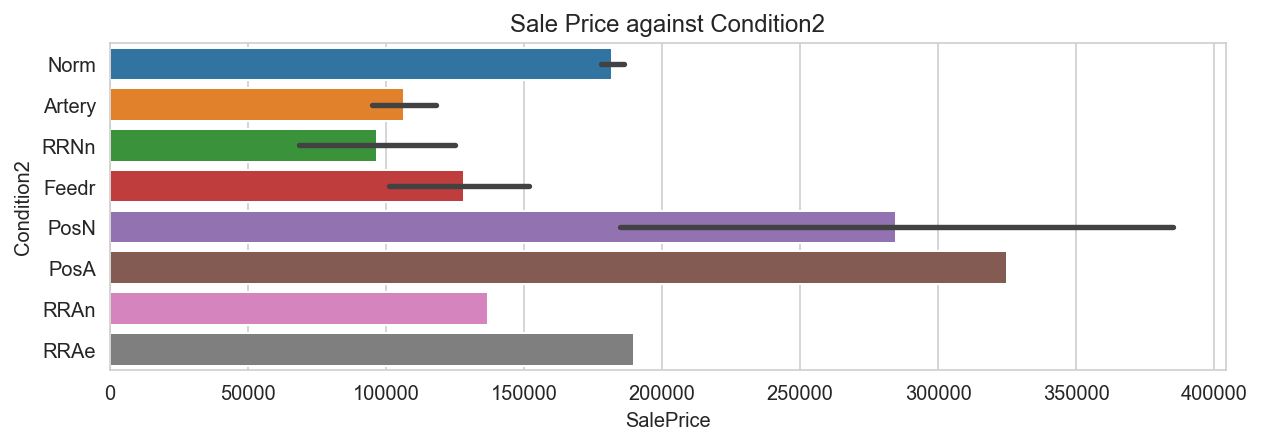

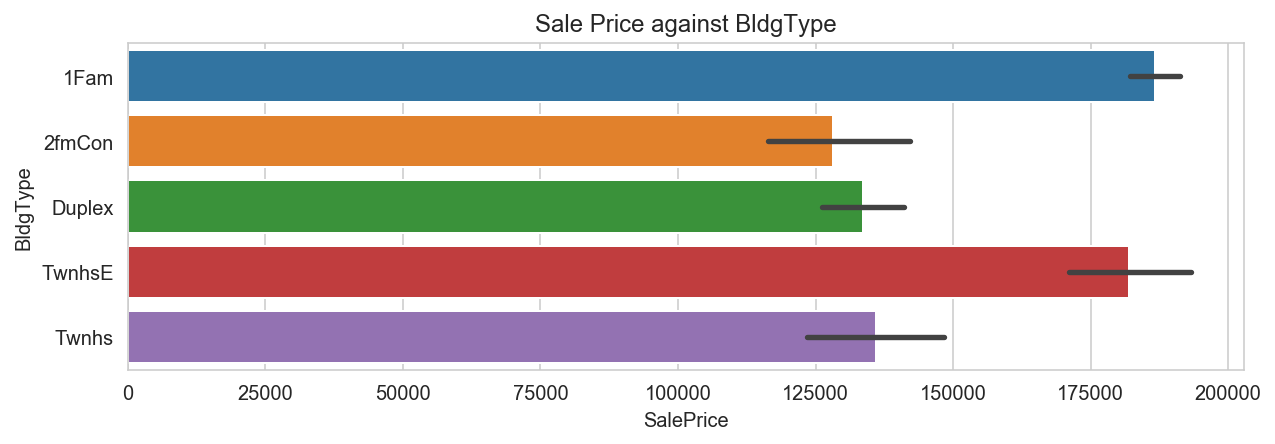

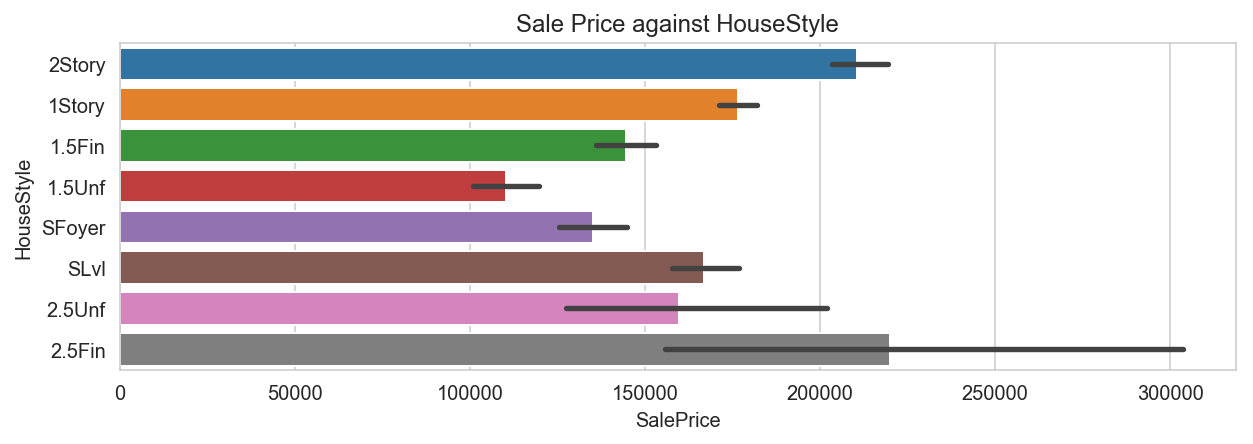

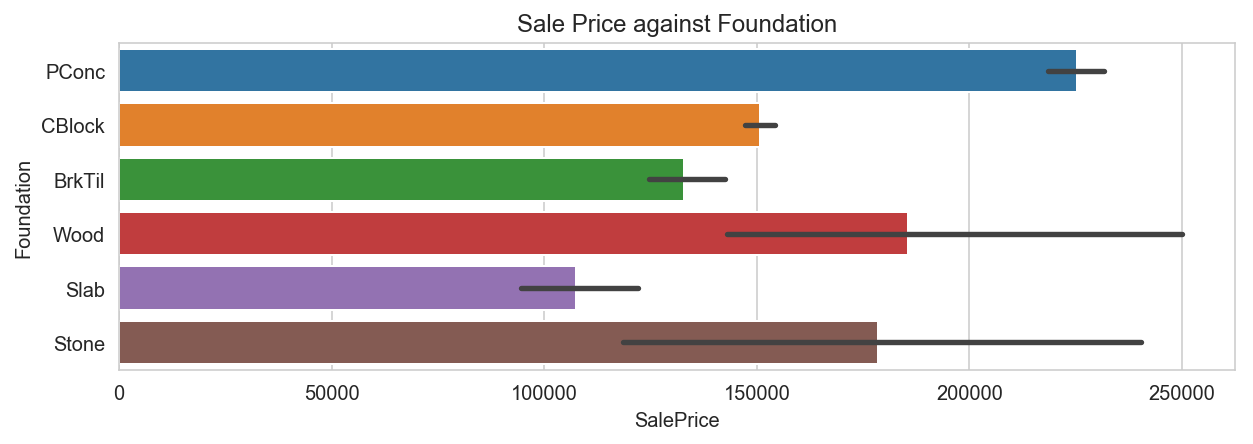

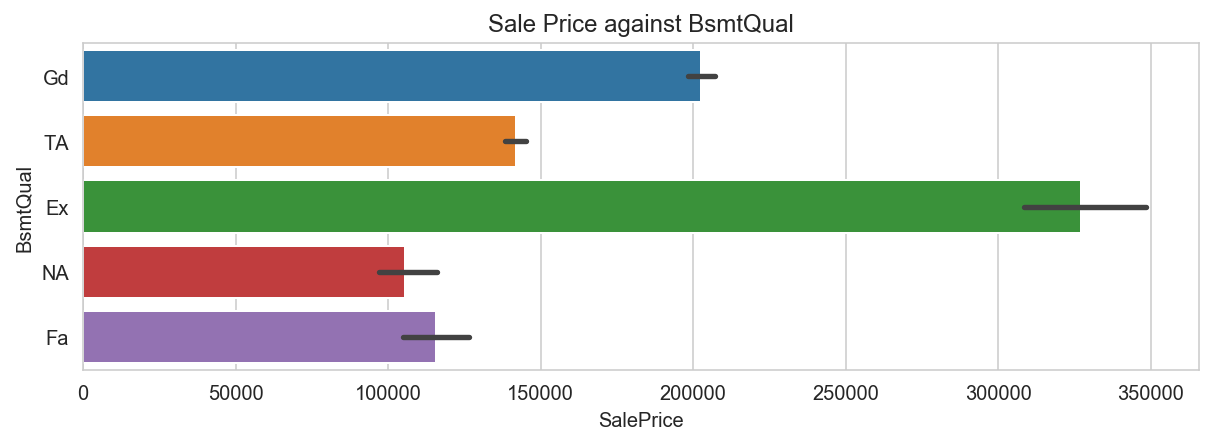

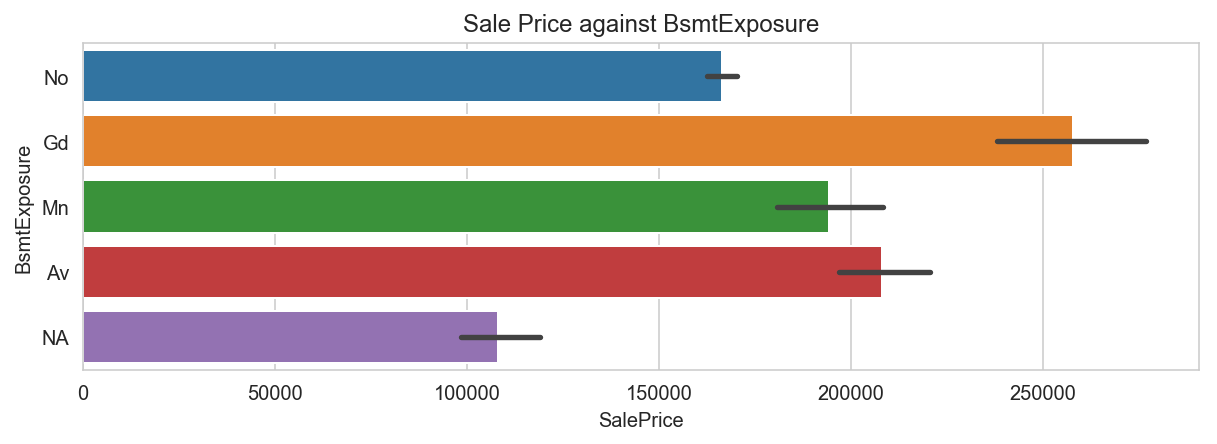

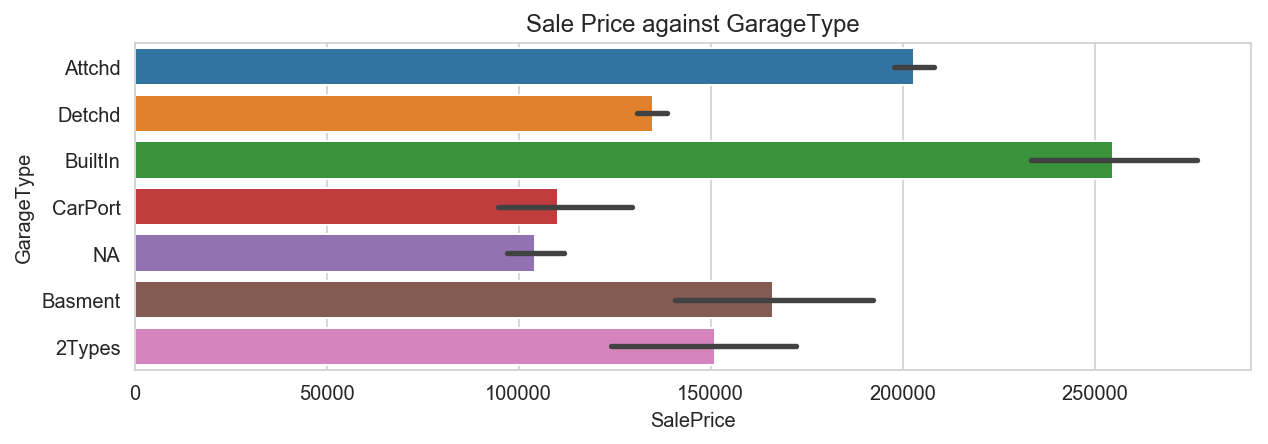

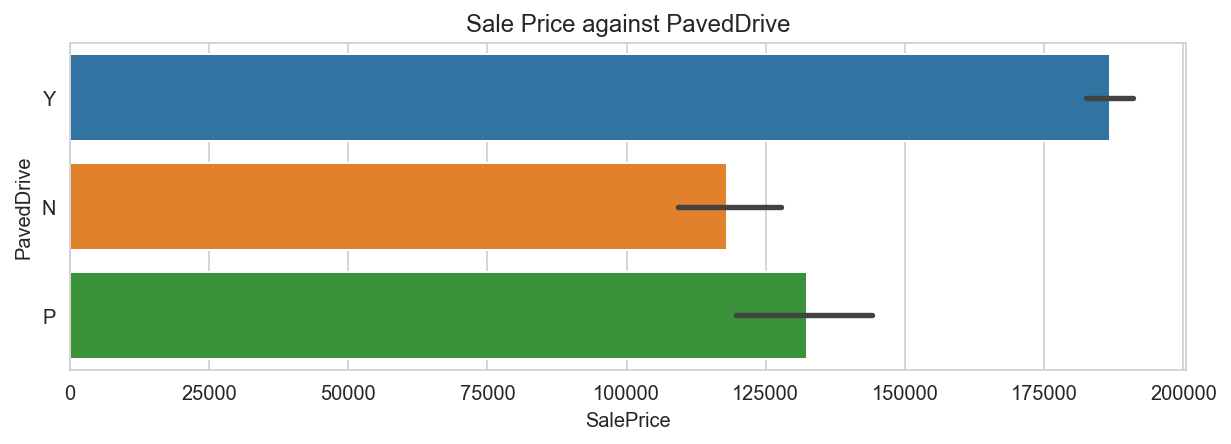

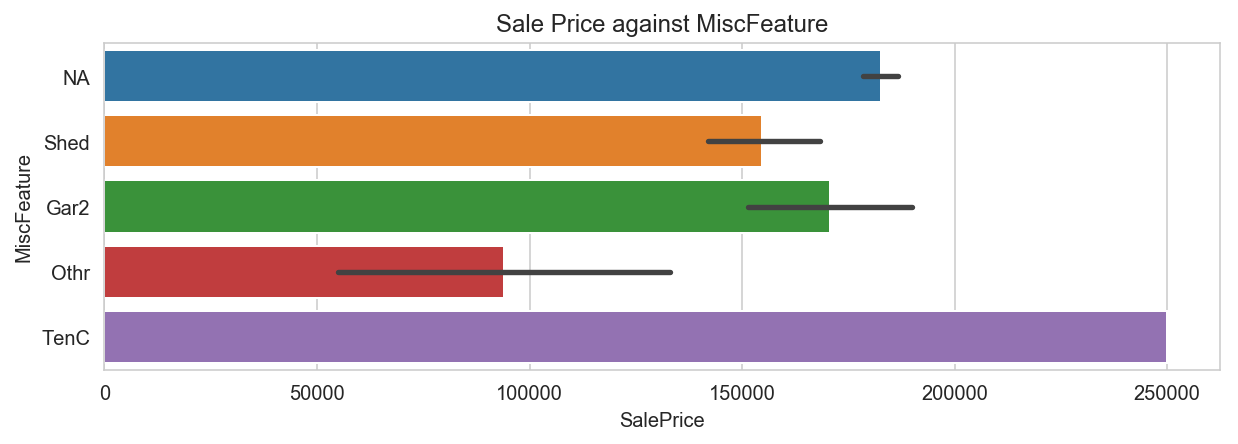

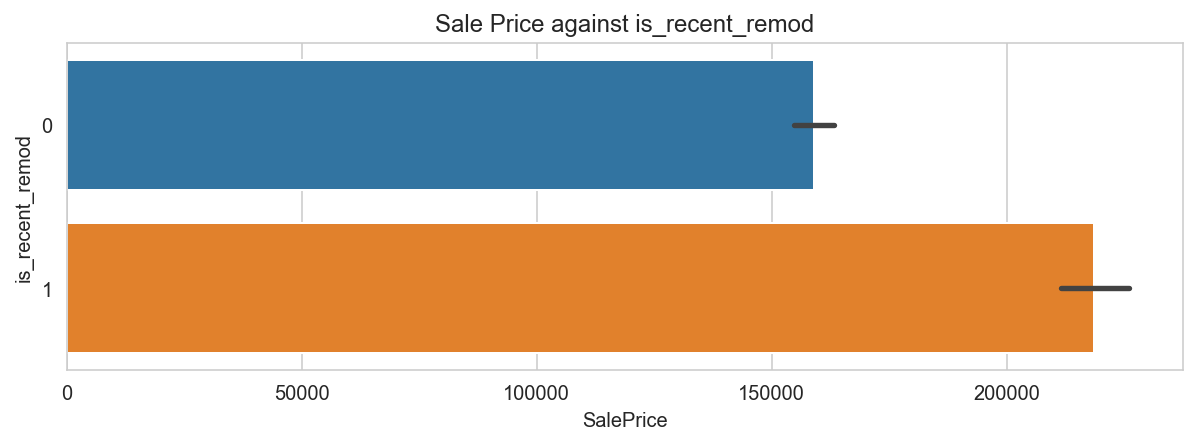

In [22]:
for col in fixed_categorical:
    plt.figure(col,figsize=(10,3))
    sns.barplot(x='SalePrice',y=col,data=house,orient="h")
    plt.title('Sale Price against '+col)

Based on the charts above, I chose the following categorical fixed variables for the feature selection:

1. Alley
2. LandContour
3. BldgType
4. GarageType
5. PavedDrive
6. is_recent_remod

In [23]:
features1 = [
    '1stFlrSF','GrLivArea','GarageArea','FullBath',
    'is_recent_remod','LandContour','PavedDrive','BldgType',
    'Alley','GarageType'  
]

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, LogisticRegression
import sklearn.metrics as metrics
from sklearn.feature_selection import SelectKBest,chi2, RFECV

In [25]:
Xf = pd.get_dummies(X_fixed[features1],drop_first=True)
X = np.array(StandardScaler().fit_transform(Xf[house.YrSold<2010]))


y = np.array(y)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [26]:
#Linear regression cross-validation scoring

kf = KFold(n_splits=10)
scores_lr = []
for train_index, test_index in kf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lr = LinearRegression()
    lr = lr.fit(X_train,y_train)
    y_test_pred = lr.predict(X_test)
    scores_lr.append(metrics.r2_score(y_test,y_test_pred))

print("Cross-validated scores:",scores_lr)
print('Cross-validated mean scores:',np.mean(scores_lr))
print("Cross-validated scores' standard deviation:",np.std(scores_lr))

Cross-validated scores: [0.8092491874950052, 0.762150664117401, 0.767570932585846, 0.6720262849680253, 0.7367751803582518, 0.7336811467030782, 0.724476473829653, 0.6751599688175238, 0.44456095746190494, 0.724817577011426]
Cross-validated mean scores: 0.7050468373348114
Cross-validated scores' standard deviation: 0.09511031439666073


In [27]:
# LASSO:
#get a range of cross-validated scores for each value of
# alpha

alpha2cv_l = {}
l_alphas = np.arange(6,10,0.1)

for alpha in l_alphas:
    cv_scores = []
    for train_index,test_index in KFold(n_splits=10).split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = Lasso(alpha=alpha)
        model = model.fit(X_train,y_train)
        y_test_pred = model.predict(X_test)
        cv_scores.append(metrics.r2_score(y_test,y_test_pred))
    alpha2cv_l[alpha] = cv_scores
    
print('LASSO scores ------>')    
print('-'*30)

for key,value in alpha2cv_l.items():
    print('alpha:',key)
    print('mean scores:',np.mean(value))
    print('scores std:',np.std(value))
    print('-'*30)

LASSO scores ------>
------------------------------
alpha: 6.0
mean scores: 0.705069513284742
scores std: 0.09529640350889941
------------------------------
alpha: 6.1
mean scores: 0.705069782117768
scores std: 0.09529950773981981
------------------------------
alpha: 6.199999999999999
mean scores: 0.7050700531596584
scores std: 0.09530263699111675
------------------------------
alpha: 6.299999999999999
mean scores: 0.7050703151326946
scores std: 0.095305743146245
------------------------------
alpha: 6.399999999999999
mean scores: 0.7050705792697277
scores std: 0.09530887485154563
------------------------------
alpha: 6.499999999999998
mean scores: 0.7050708362837842
scores std: 0.09531198307205424
------------------------------
alpha: 6.599999999999998
mean scores: 0.7050710900178327
scores std: 0.09531509192357195
------------------------------
alpha: 6.6999999999999975
mean scores: 0.7050713438252021
scores std: 0.09531822709116704
------------------------------
alpha: 6.7999999999

From the above, the optimal alpha = 9.9, and R^2 score = 0.70508.

In [28]:
# Ridge:
# get a range of cross-validated scores for each value of
# alpha

alpha2cv_r = {}
r_alphas = np.logspace(0.2, 2, 20)

for alpha in r_alphas:
    cv_scores = []
    for train_index,test_index in KFold(n_splits=10).split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = Ridge(alpha=alpha)
        model = model.fit(X_train,y_train)
        y_test_pred = model.predict(X_test)
        cv_scores.append(metrics.r2_score(y_test,y_test_pred))
    alpha2cv_r[alpha] = cv_scores

print('Ridge scores ------>')    
print('-'*30)

for key,value in alpha2cv_r.items():
    print('alpha:',key)
    print('mean scores:',np.mean(value))
    print('scores std:',np.std(value))
    print('-'*30)

Ridge scores ------>
------------------------------
alpha: 1.5848931924611136
mean scores: 0.7051462376139461
scores std: 0.09582222517111803
------------------------------
alpha: 1.971227921517696
mean scores: 0.7051317016136325
scores std: 0.09594109363568647
------------------------------
alpha: 2.451735887979287
mean scores: 0.7051028698831582
scores std: 0.09606798841315867
------------------------------
alpha: 3.04937282938726
mean scores: 0.7050557685271718
scores std: 0.0961989293263071
------------------------------
alpha: 3.79269019073225
mean scores: 0.7049869393141085
scores std: 0.09632839432581618
------------------------------
alpha: 4.7171991382132985
mean scores: 0.704894225862829
scores std: 0.09644938787433006
------------------------------
alpha: 5.8670670659931
mean scores: 0.70477758644481
scores std: 0.09655366350989766
------------------------------
alpha: 7.297227644686393
mean scores: 0.7046397157342358
scores std: 0.09663204413633729
-------------------------

From Ridge, the optimal alpha = 1.5848931924611136 and R^2 score = 0.70514.

Hence, I will choose Ridge, as it performs marginally better than Ordinary Least Squares Regression and LASSO Regression.

In [29]:
ridgereg = Ridge(alpha=1.5848931924611136)
ridgereg = ridgereg.fit(X,y)

In [30]:
coef = pd.DataFrame(ridgereg.coef_,index=Xf.columns,columns=['coef'])
coef['coef_abs'] = np.abs(coef.coef)
coef.sort_values('coef_abs',ascending=False)

,coef,coef_abs
GrLivArea,32588.375416,32588.375416
GarageType_Attchd,31692.330632,31692.330632
GarageType_Detchd,22280.966748,22280.966748
GarageArea,21026.423006,21026.423006
GarageType_BuiltIn,18174.000384,18174.000384
GarageType_NA,17755.308678,17755.308678
1stFlrSF,12668.669196,12668.669196
is_recent_remod,10721.938369,10721.938369
LandContour_HLS,8691.425677,8691.425677
BldgType_Duplex,-7942.317037,7942.317037


In [31]:
X_test = np.array(StandardScaler().fit_transform(Xf[house.YrSold==2010]))

y_hold = np.array(y_holdout)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [32]:
#check final model against test set

y_pred = ridgereg.predict(X_test)
print("Model's score against hold-out set:",metrics.r2_score(y_hold,y_pred))

Model's score against hold-out set: 0.7514839803161235


In [33]:
#standard deviation of GrLivArea for pre-2010 prices
Xf[house.YrSold<2010]['GrLivArea'].std()

528.2574296108381

In [34]:
# coefficient divided by standard deviation(GrLivArea) = price increase per sq ft 
32588.375416 / (Xf[house.YrSold<2010]['GrLivArea'].std())

61.69033048907144

When the trained model is tested against data from 2010, the R^2 score is 0.751.

From the R^2 score of 0.751, I conclude that the model predicts price moderately well. Of course, the model can be further optimised by adding/subtracting features.

The best estimator of SalePrice is GrLivArea (above grade living area square feet), as it had the largest absolute coefficient of 32588.375416. I then take the coefficient divided by the standard deviation of pre-2010 GrLivArea data, which equals to : 

$\frac{32588.375416}{528.2574296108381} = 61.69033048907144 $

It meant that when I increased the above grade living area by 1 square feet, the sale price will increase by approximately $61.69.


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [35]:
# residuals data from model in Question 1

residuals_train = y - ridgereg.predict(X) 
residuals_test = y_hold - y_pred

C:\Users\hp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


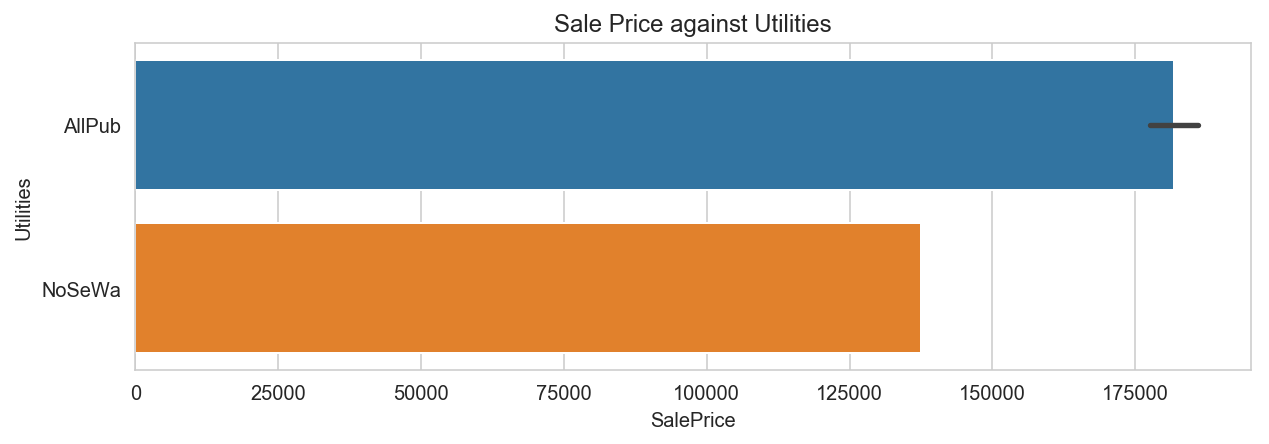

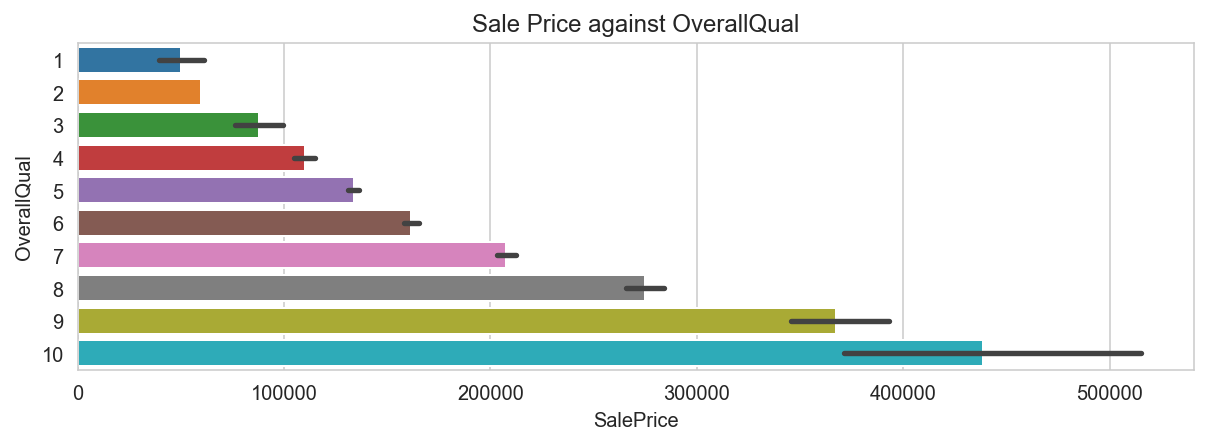

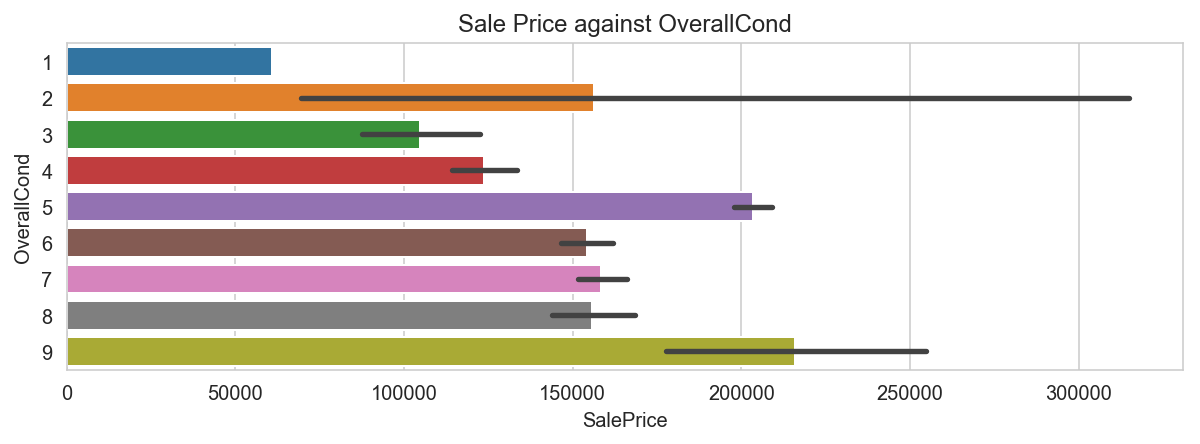

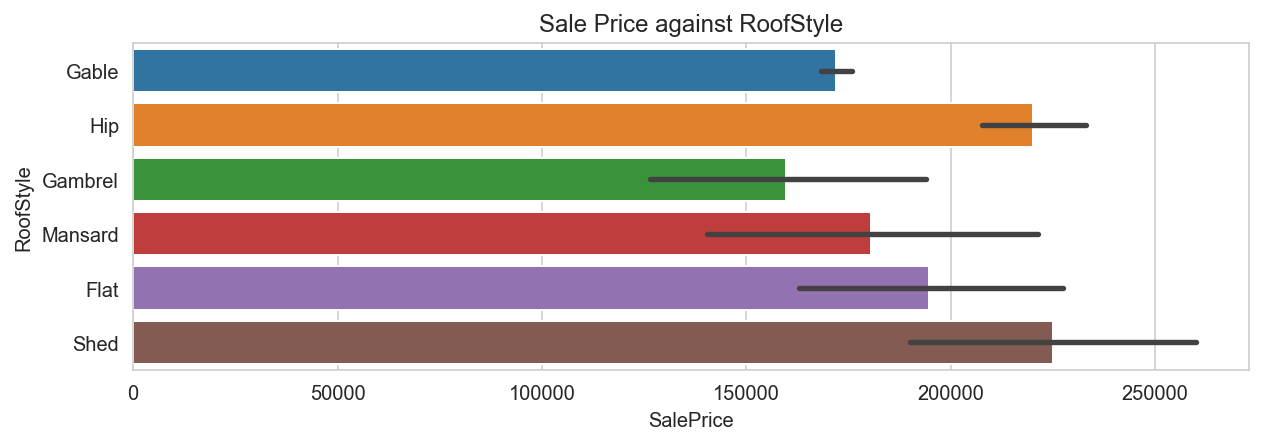

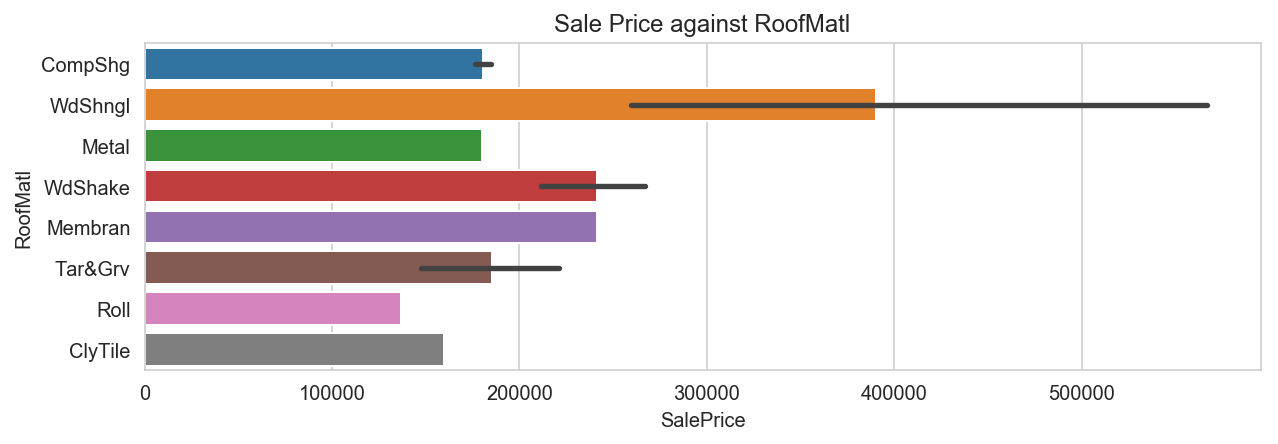

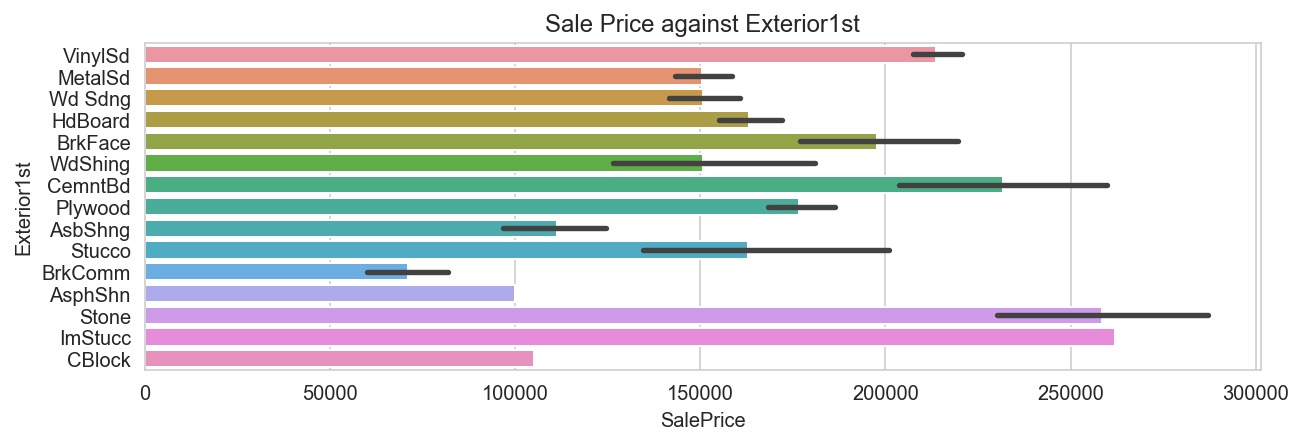

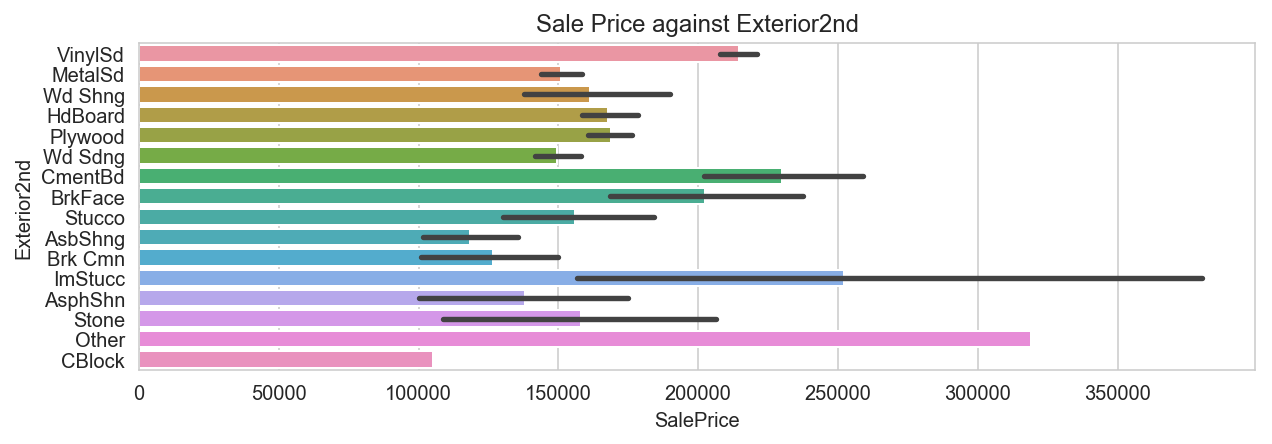

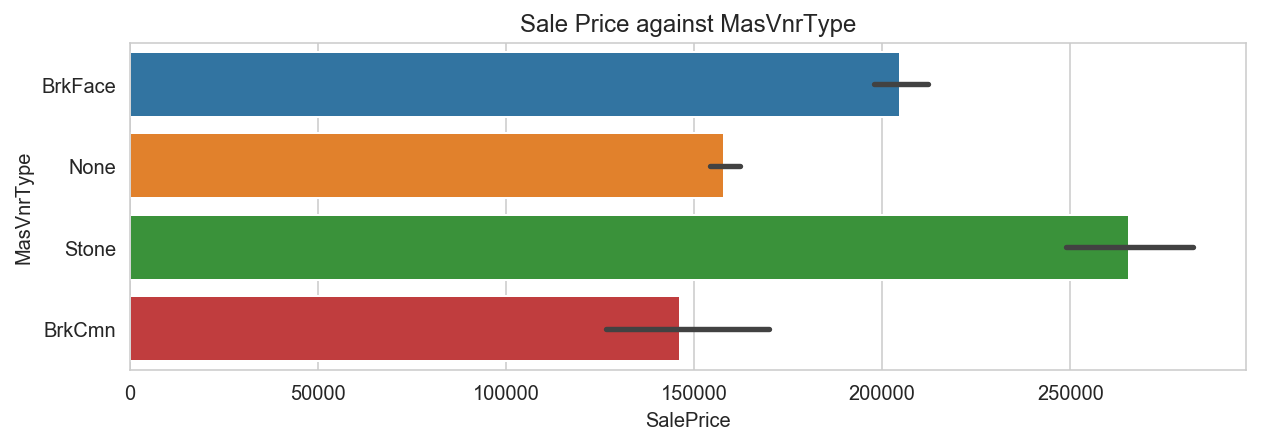

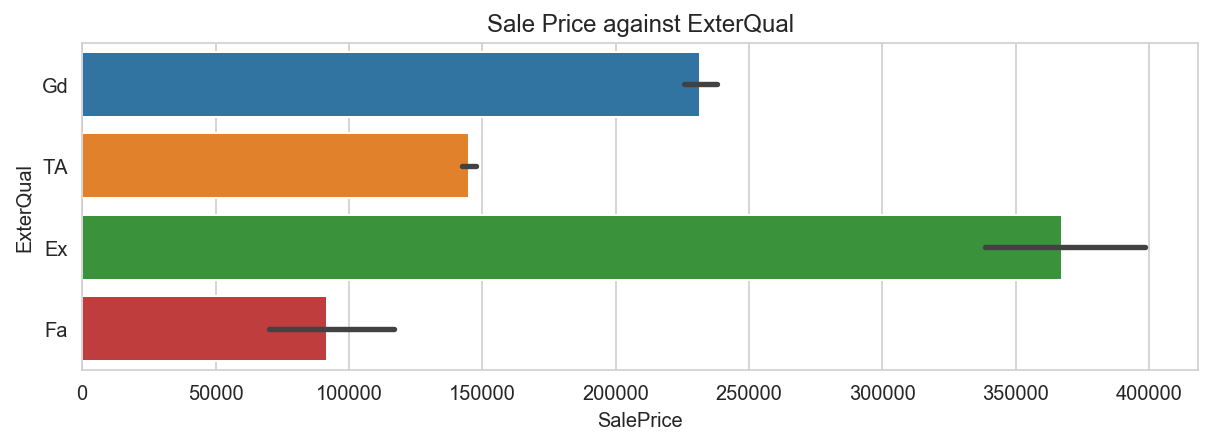

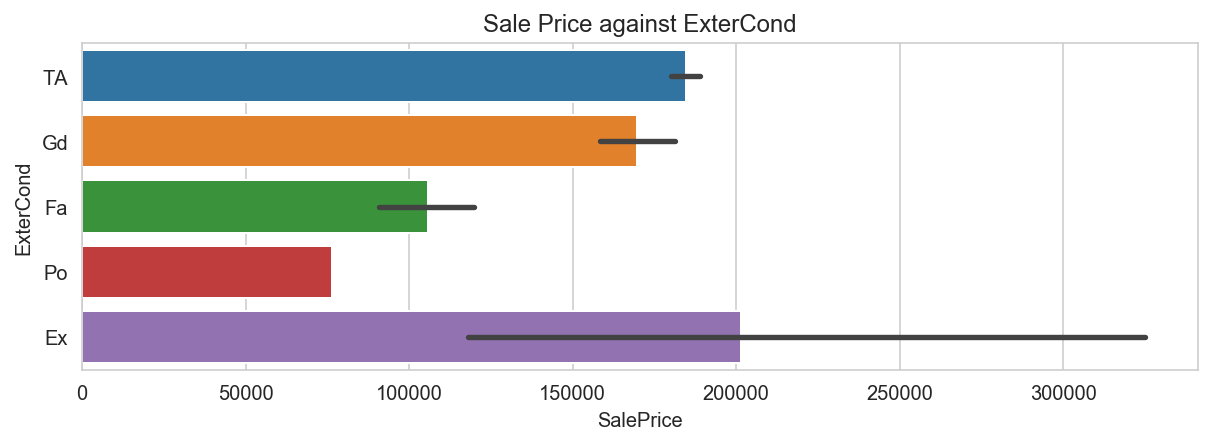

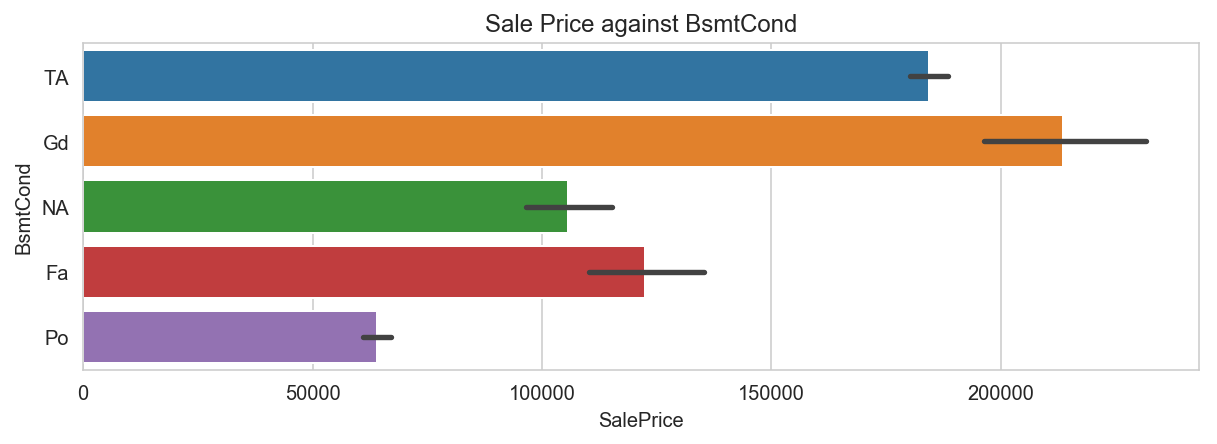

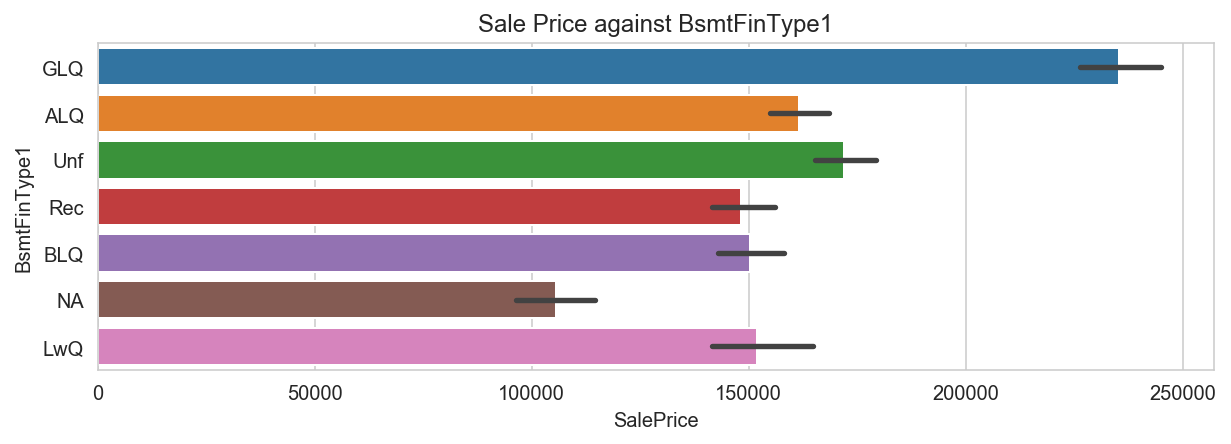

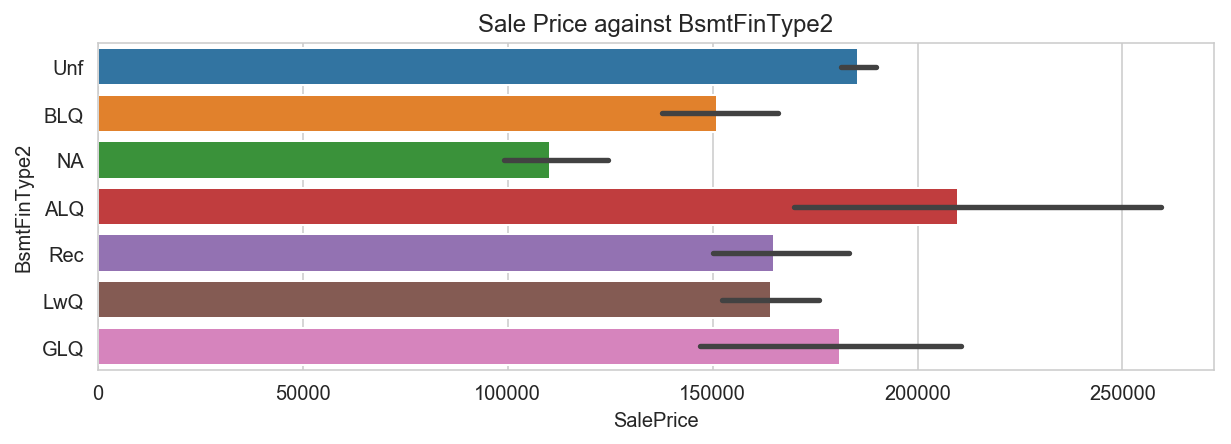

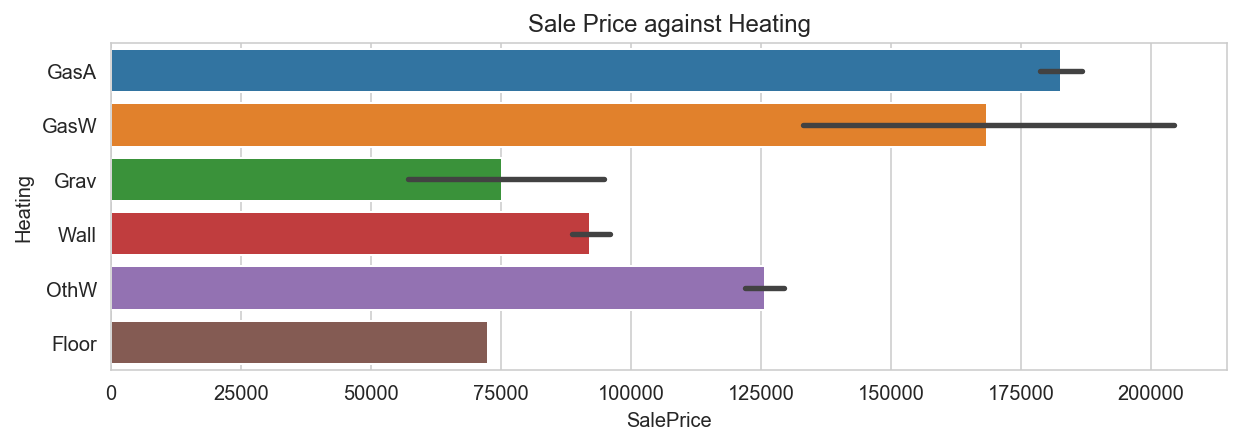

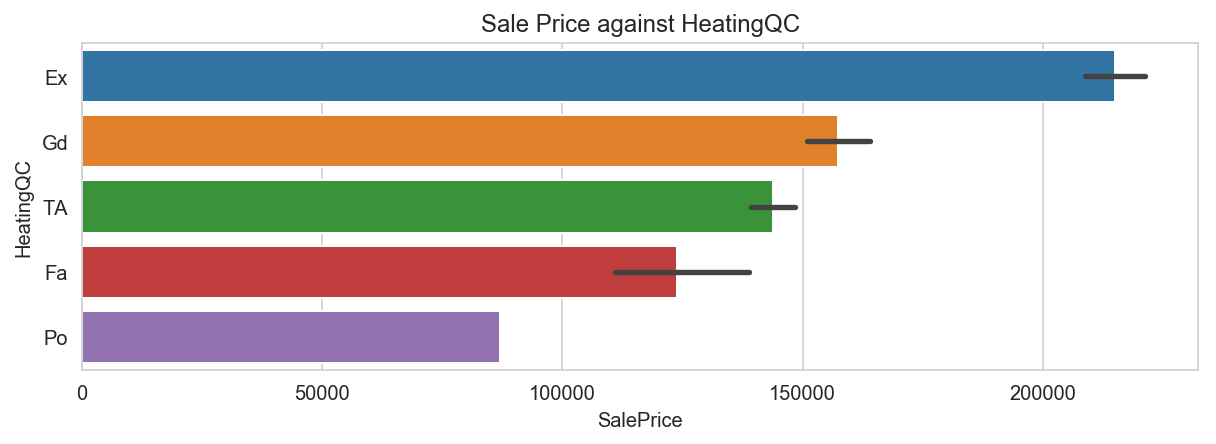

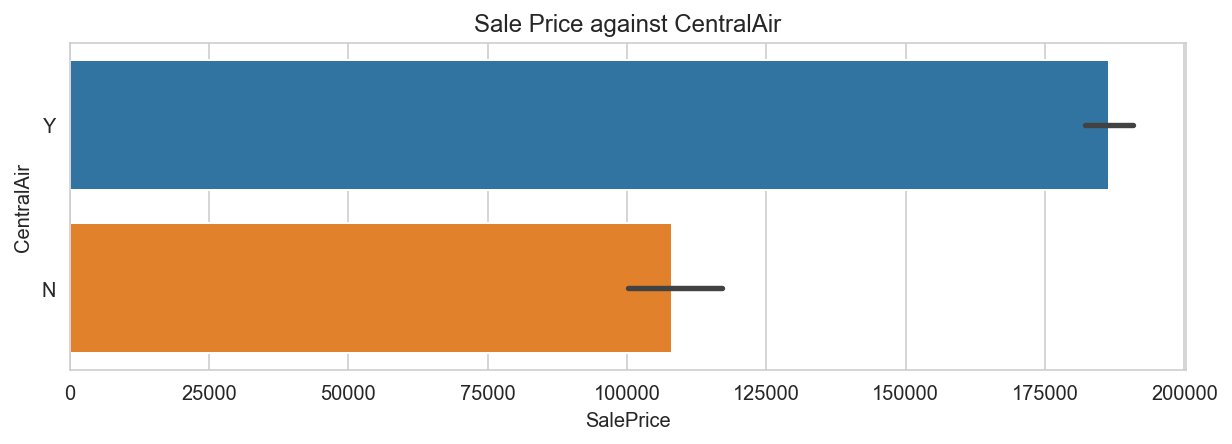

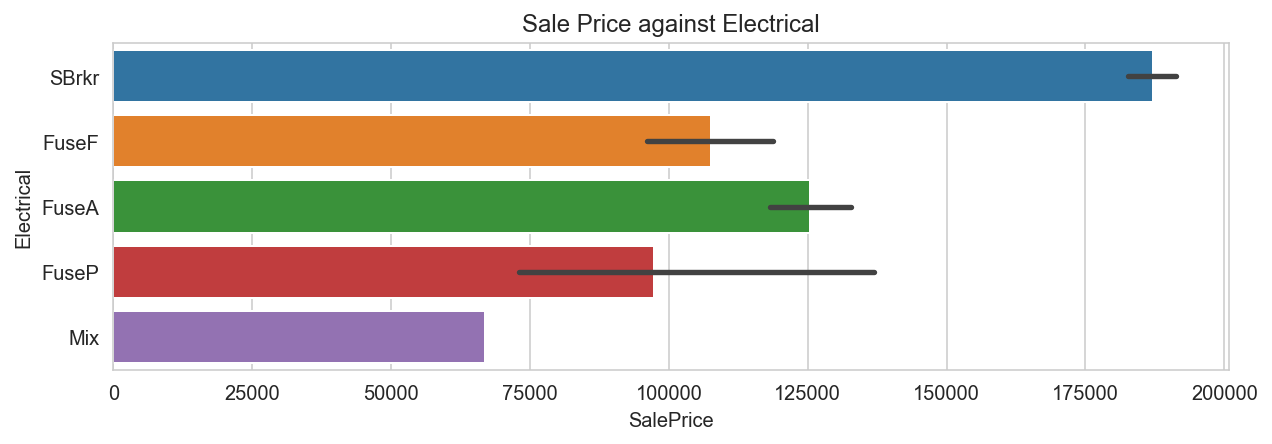

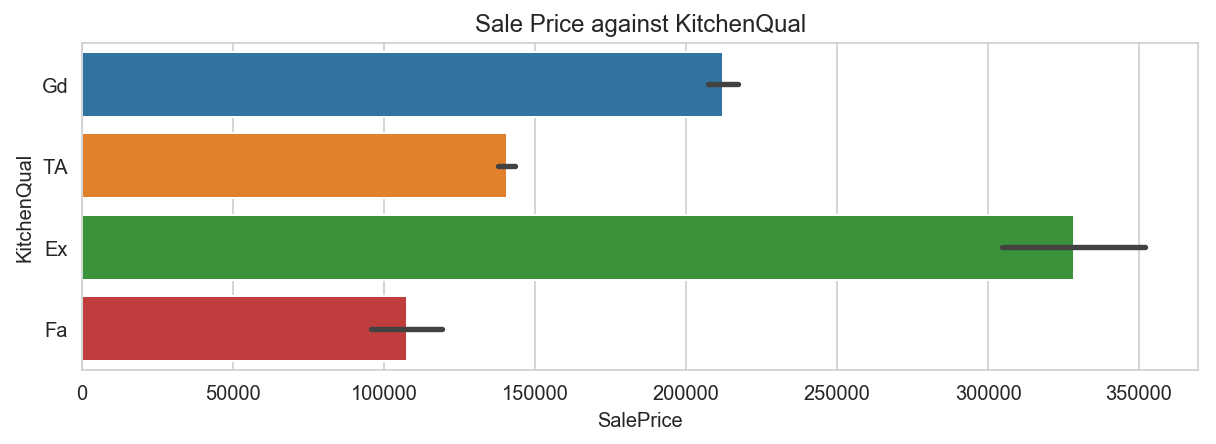

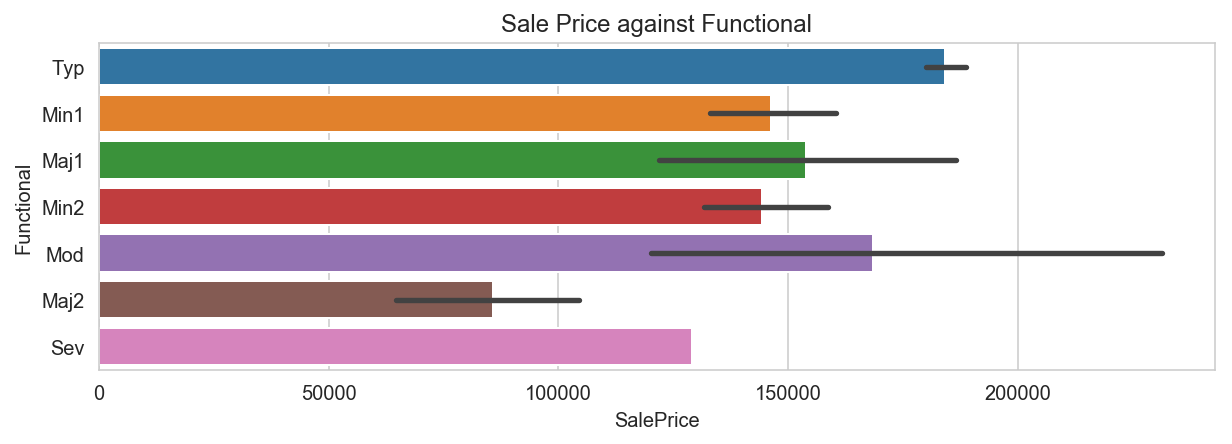

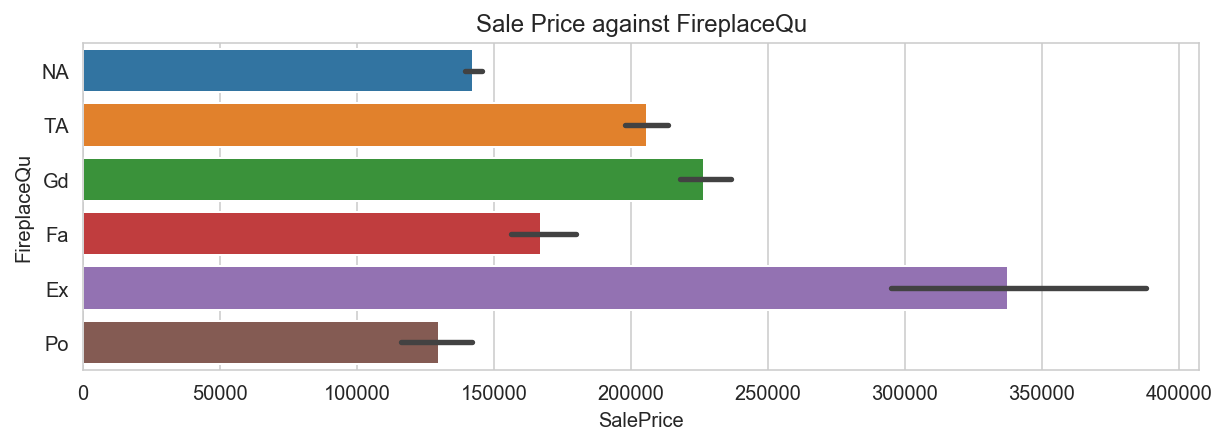

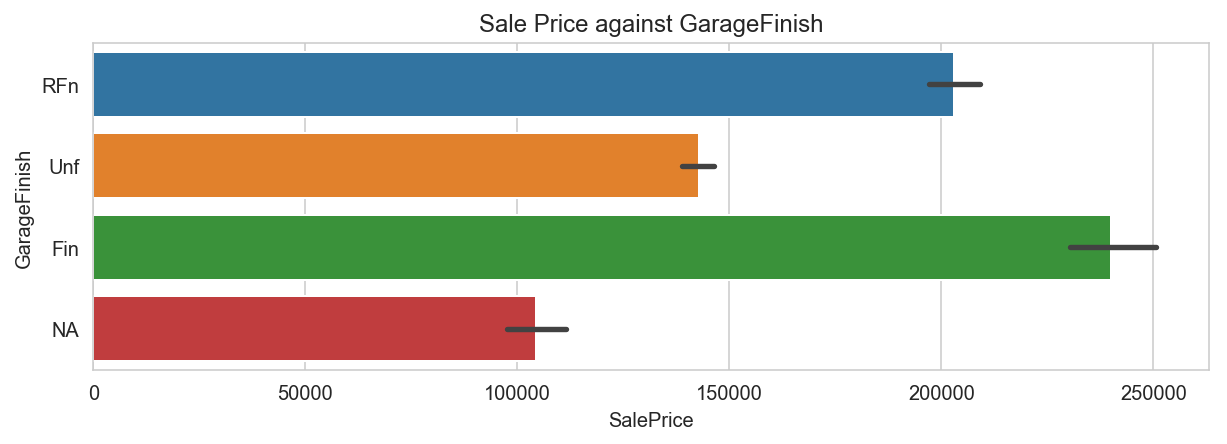

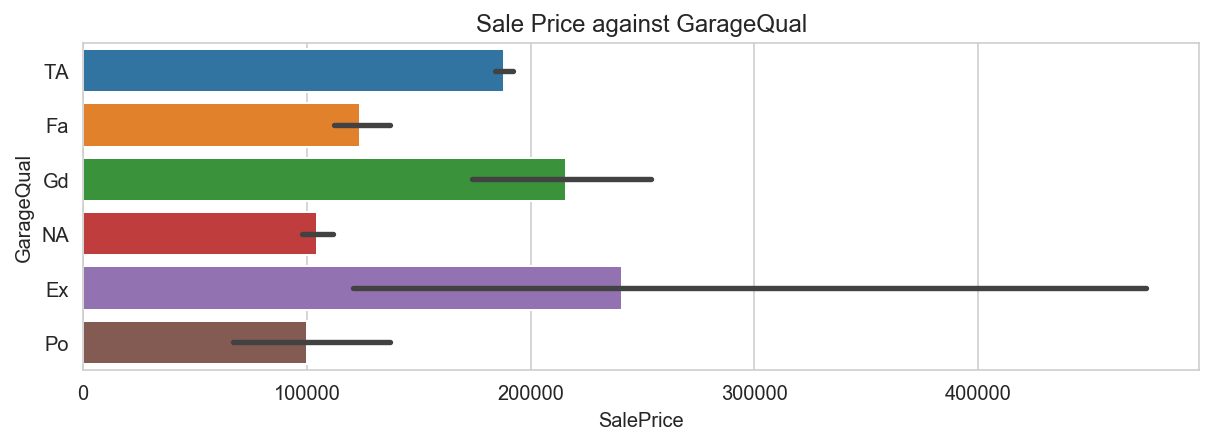

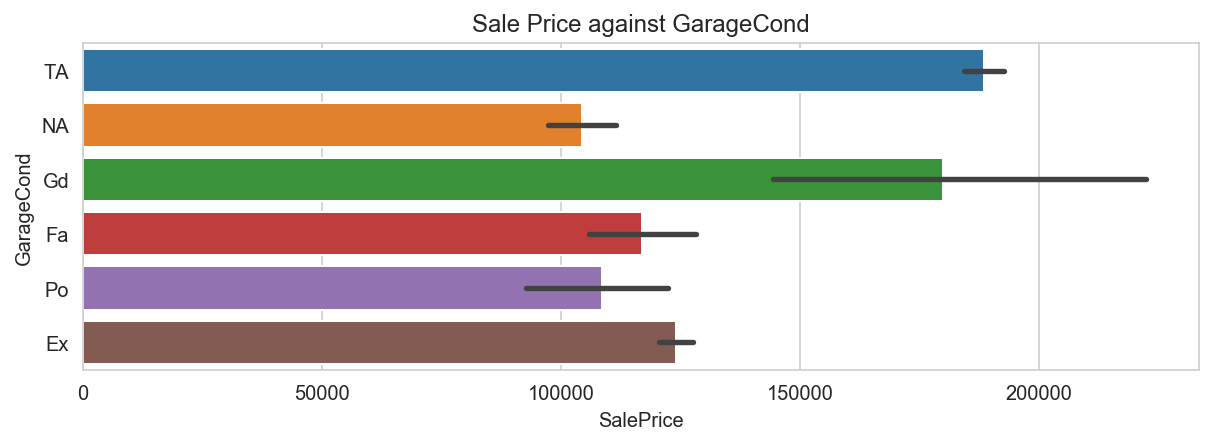

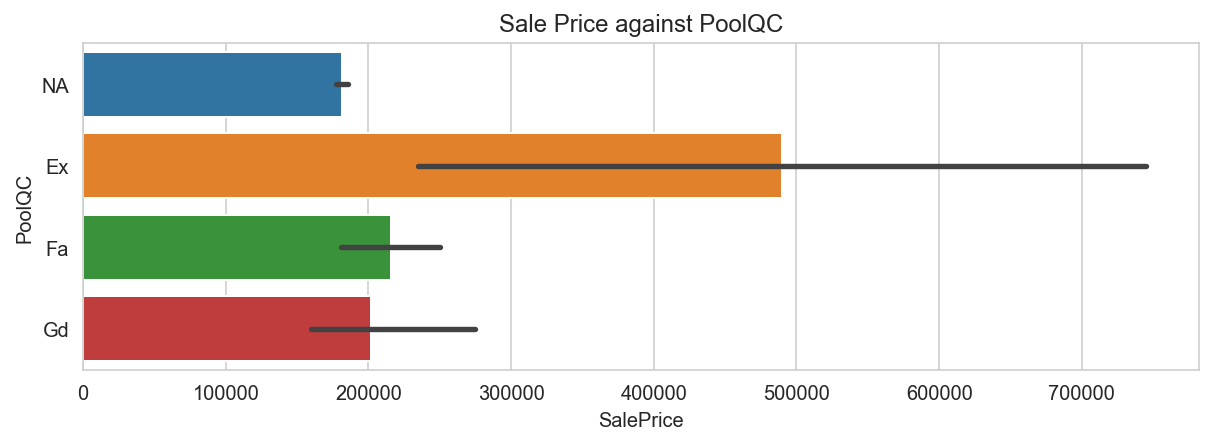

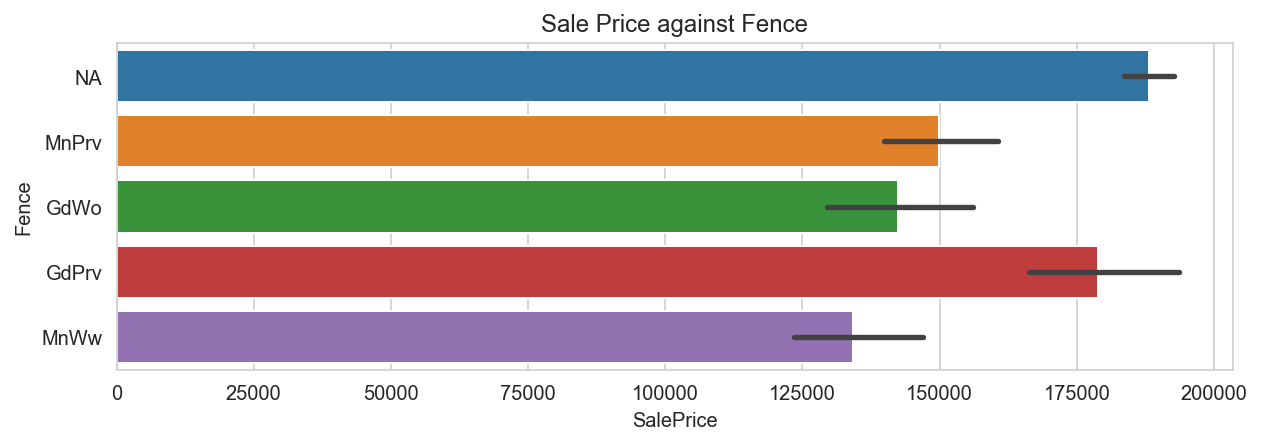

In [36]:
# look at charts and choose suitable predictors
for col in renov:
    plt.figure(col,figsize=(10,3))
    sns.barplot(x='SalePrice',y=col,data=house,orient="h")
    plt.title('Sale Price against '+col)

Since I want to see which renovatable features will improve the sale price, I will incoporate every renovatable feature into the second model.

In [37]:
X_renov = pd.get_dummies(house[renov],drop_first=True)
X_renov_train = X_renov[house.YrSold<2010].values
X_renov_test = X_renov[house.YrSold==2010].values

In [38]:
#Linear regression cross-validation scoring

kf = KFold(n_splits=10)
scores2_lr = []
for train_index, test_index in kf.split(X_renov_train,residuals_train):
    X_train, X_test = X_renov_train[train_index], X_renov_train[test_index]
    y_train, y_test = residuals_train[train_index], residuals_train[test_index]
    
    lr = LinearRegression()
    lr = lr.fit(X_train,y_train)
    y_test_pred = lr.predict(X_test)
    scores2_lr.append(metrics.r2_score(y_test,y_test_pred))

print("Cross-validated scores:",scores2_lr)
print('Cross-validated mean scores:',np.mean(scores2_lr))
print("Cross-validated scores' standard deviation:",np.std(scores2_lr))

Cross-validated scores: [-5.242318676706561e+24, -4.443297933844003e+23, -3.100153437245858e+22, -0.2687682895825614, -3.98767416266855e+20, 0.19181026454353045, -1.1308359889770323e+23, 0.09249151591171878, -8.763700708091484e+22, -3.2622204354051696e+22]
Cross-validated mean scores: -5.9513915822123565e+23
Cross-validated scores' standard deviation: 1.5543462131928078e+24


In [39]:
#use LASSO and compare score results

optimal_lasso2 = LassoCV(n_alphas=500,verbose=1,max_iter=2000,cv=10)
optimal_lasso2.fit(X_renov_train,residuals_train)

fit_lasso2 = Lasso(alpha=optimal_lasso2.alpha_).fit(X_renov_train,residuals_train)

scores2_lasso = cross_val_score(Lasso(alpha=optimal_lasso2.alpha_),X_renov_train,residuals_train,cv=10)

print("Cross-validated scores:",scores2_lasso)
print('Cross-validated mean scores:',np.mean(scores2_lasso))
print("Cross-validated scores' standard deviation:",np.std(scores2_lasso))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Cross-validated scores: [ 0.15081708  0.26914957  0.36778242 -0.01150488  0.25906989  0.18955507
  0.02369928  0.23135824  0.06378488  0.23707645]
Cross-validated mean scores: 0.17807880083201838
Cross-validated scores' standard deviation: 0.11439988695428484


In [40]:
#use Ridge and compare score results
ridge_alphas = np.logspace(-2, 7, 50)
optimal_ridge2 = RidgeCV(alphas = ridge_alphas,cv=10)
optimal_ridge2.fit(X_renov_train,residuals_train)

fit_ridge2 = Ridge(alpha=optimal_ridge2.alpha_).fit(X_renov_train,residuals_train)

scores2_ridge = cross_val_score(Ridge(alpha=optimal_ridge2.alpha_),X_renov_train,residuals_train,cv=10)

print("Cross-validated scores:",scores2_ridge)
print('Cross-validated mean scores:',np.mean(scores2_ridge))
print("Cross-validated scores' standard deviation:",np.std(scores2_ridge))

Cross-validated scores: [ 0.12953729  0.27405806  0.36912493 -0.04378673  0.28136466  0.2101288
  0.04264334  0.20482835  0.03084587  0.25164207]
Cross-validated mean scores: 0.1750386644248002
Cross-validated scores' standard deviation: 0.12451561179894022


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Since the scores increased drastically with regularisation, I will use LASSO for my second model.

In [41]:
#check final model against test set

model2 = Lasso(optimal_lasso2.alpha_).fit(X_renov_train,residuals_train)
residuals_pred = model2.predict(X_renov_test)
score_model2 = metrics.r2_score(residuals_test,residuals_pred)
print("Model's score against hold-out set:",score_model2)

Model's score against hold-out set: 0.22585749095175012


The model's score against 2010 data is generally better than the mean cross-validated score of the train data, which is a good sign.

However, the fact that the R^2 score is quite low shows that the renovatable features do not explain the varialibility of the residuals that much.

In [42]:
coef2 = pd.DataFrame(model2.coef_,index=X_renov.columns,columns=['coef'])
coef2['coef_abs'] = np.abs(coef2.coef)
coef2.sort_values('coef_abs',ascending=False)

,coef,coef_abs
Functional_Typ,21376.223914,21376.223914
KitchenQual_Gd,-17483.219399,17483.219399
BsmtFinType1_GLQ,10211.958679,10211.958679
KitchenQual_TA,-8659.842578,8659.842578
OverallQual,8038.130373,8038.130373
BsmtFinType1_Unf,-7851.893177,7851.893177
GarageFinish_RFn,-6318.322052,6318.322052
Exterior1st_BrkFace,4383.942108,4383.942108
OverallCond,4218.064000,4218.064000
GarageQual_TA,-3095.259860,3095.259860


In [43]:
#standard deviation of Functional_Typ for pre-2010 prices
X_renov[house.YrSold<2010]['Functional_Typ'].std()

0.25062620485142967

In [44]:
# coefficient divided by standard deviation(Functional_Typ) = price increase on average
# when house have typical functionality
21376.223914 / (X_renov[house.YrSold<2010]['Functional_Typ'].std())

85291.25646167666

From the coefficients, the strongest renovatable predictor will be Functional_Typ (Typical Functionality), which has a coefficient of 21376.223914.

The LASSO suggest that we improve the house functionality to a typical level, so that the house can be sold for 

$ \frac{21376.223914}{0.25062620485142967} = 85291$ dollars

more than a house with functionality of salvage value only.

## Recommendations

By comparing the two models in Question 1 and 2, we conclude that sale price is determined mostly by its fixed features, as shown by the R^2 score of the first model as compared to the second one. 

Since GrLivArea(above grade living area square feet) has the highest coefficient in the first model, we can use that to determine whether we should buy a house or not. The bigger the above grade living area, the higher price the house can fetch.

After that, we can determine whether to sell the house at a even higher price by improving the house functionality to a typical level. Realistically, it makes sense as most house viewers will view the houses, ask questions regarding the functionality and validate them through the house-viewing.

## Variance in Price Explained by Renovatable Features?

Question: Investigate how much of the variance in price remaining is explained by these features.

Answer: From the R^2 score of the second model, the renovatable features only explain about 22% of the variance of the price residuals.

## Evaluation of Models

Question: Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

Answer: By comparing the scores of the two models in Question 1 and 2, the R^2 score of the first model is a lot higher than the second one. Hence I will put more faith in the first model that predicts sale prices based on fixed features. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from random import sample
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report

In [46]:
house.SaleCondition.value_counts(dropna=False)

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [47]:
#create binary values, 1 if salecondition is abnormal, 0 for everything else
house['is_abnormal'] = house.SaleCondition.apply(lambda x: 1 if x=='Abnorml' else 0)
house.is_abnormal.value_counts()

0    1354
1      96
Name: is_abnormal, dtype: int64

From above, only about 7% of the observations were abnormal. If I were to use this set of data to predice whether a sale is abnormal, I will get a "normal" sale prediction 93% of the time.

Next, I will use the fixed features I have selected in Question 1, and some other sales-related variables as predictors for this classification model.

In [48]:
features_salescond = ['MoSold','YrSold','SalePrice'] + features1

y3 = house.is_abnormal

In [49]:
y3 = house.is_abnormal.values
X3 = house[features_salescond]
X3.MoSold = X3.MoSold.astype('object')
X3.YrSold = X3.YrSold.astype('object')

features_salescond_cat = []
features_salescond_rest = []
for col in X3.columns:
    if X3[col].dtype =='object':
        features_salescond_cat.append(col)
    else:
        features_salescond_rest.append(col)

dummies_salescond = pd.get_dummies(X3[features_salescond_cat],drop_first=True)
X3_new = pd.concat([X3[features_salescond_rest],dummies_salescond],axis=1)
X3s = pd.DataFrame(StandardScaler().fit_transform(X3_new),columns=X3_new.columns).values

C:\Users\hp\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [50]:
# create train-test set
X3train,X3test,y3train,y3test=train_test_split(X3s,y3,test_size=0.2,stratify=y3)

In [51]:
scores_logreg = []
skf =StratifiedKFold(n_splits=10)
for train_index, test_index in skf.split(X3train,y3train):

    X_train, X_test = X3train[train_index], X3train[test_index]
    y_train, y_test = y3train[train_index], y3train[test_index]
    
    #random oversampling
    ros = RandomOverSampler()
    X_ros, y_ros = ros.fit_sample(X_train,y_train)
   
    logreg = LogisticRegression(penalty='l1',solver='liblinear')
    logreg.fit(X_ros,y_ros)
    score = logreg.score(X_test,y_test)
    scores_logreg.append(score)

print('Cross-validated scores:',scores_logreg)
print('Mean cross-validated scores:',np.mean(scores_logreg))
print("Cross-validated scores' standard deviation:", np.std(scores_logreg))

Cross-validated scores: [0.6666666666666666, 0.7094017094017094, 0.7350427350427351, 0.7672413793103449, 0.75, 0.646551724137931, 0.6551724137931034, 0.7217391304347827, 0.7043478260869566, 0.7130434782608696]
Mean cross-validated scores: 0.7069207063135099
Cross-validated scores' standard deviation: 0.03807596912685087


In [52]:
baseline_acc = 1 - y3.mean()
baseline_acc

0.9337931034482758

In [53]:
#fit to final model

logreg = LogisticRegression(penalty='l1',solver='liblinear')
X_ros, y_ros = RandomOverSampler().fit_sample(X3train,y3train)
logreg.fit(X_ros,y_ros)
logreg_pred = logreg.predict(X3test)

In [54]:
logreg_coef = pd.DataFrame(logreg.coef_[0],index=X3_new.columns,columns=['coef'])
logreg_coef['odds'] = np.exp(logreg_coef.coef)
logreg_coef.sort_values('odds',ascending=False)

,coef,odds
1stFlrSF,0.693693,2.001093
Alley_Pave,0.394930,1.484280
GrLivArea,0.387420,1.473175
LandContour_Low,0.264848,1.303233
LandContour_Lvl,0.149264,1.160980
GarageType_Basment,0.111097,1.117503
Alley_NA,0.088944,1.093020
GarageType_CarPort,0.081055,1.084430
PavedDrive_Y,0.048863,1.050076
BldgType_Twnhs,-0.005661,0.994355


In [ ]:
print('Average 1st Floor Square Feet:',np.mean(X3train))

From the coefficients which is converted to odds, it seems that 1stFlrSF (1st floor square feet) is the top feature that determines whether the sale type is abnormal. For example, for one standard deviation increase of 1st floor square feet, the sale is about twice as likely to be abnormal.

In [55]:
conmat1 = np.array(confusion_matrix(y3test,logreg_pred))
confusion1 = pd.DataFrame(conmat1,index=['is_normal','is_abnormal'],
                         columns=['predicted_normal','predicted_abnormal'])
confusion1

,predicted_normal,predicted_abnormal
is_normal,181,90
is_abnormal,9,10


In [56]:
logreg_pp = pd.DataFrame(logreg.predict_proba(X3test), columns=['class0_pp','class1_pp'])
logreg_pp.head()

,class0_pp,class1_pp
0,0.530762,0.469238
1,0.377390,0.622610
2,0.186004,0.813996
3,0.823169,0.176831
4,0.304783,0.695217


In [57]:
print(classification_report(y3test,logreg_pred))

              precision    recall  f1-score   support

           0       0.95      0.67      0.79       271
           1       0.10      0.53      0.17        19

   micro avg       0.66      0.66      0.66       290
   macro avg       0.53      0.60      0.48       290
weighted avg       0.90      0.66      0.74       290



In [58]:
from sklearn.metrics import roc_curve, auc

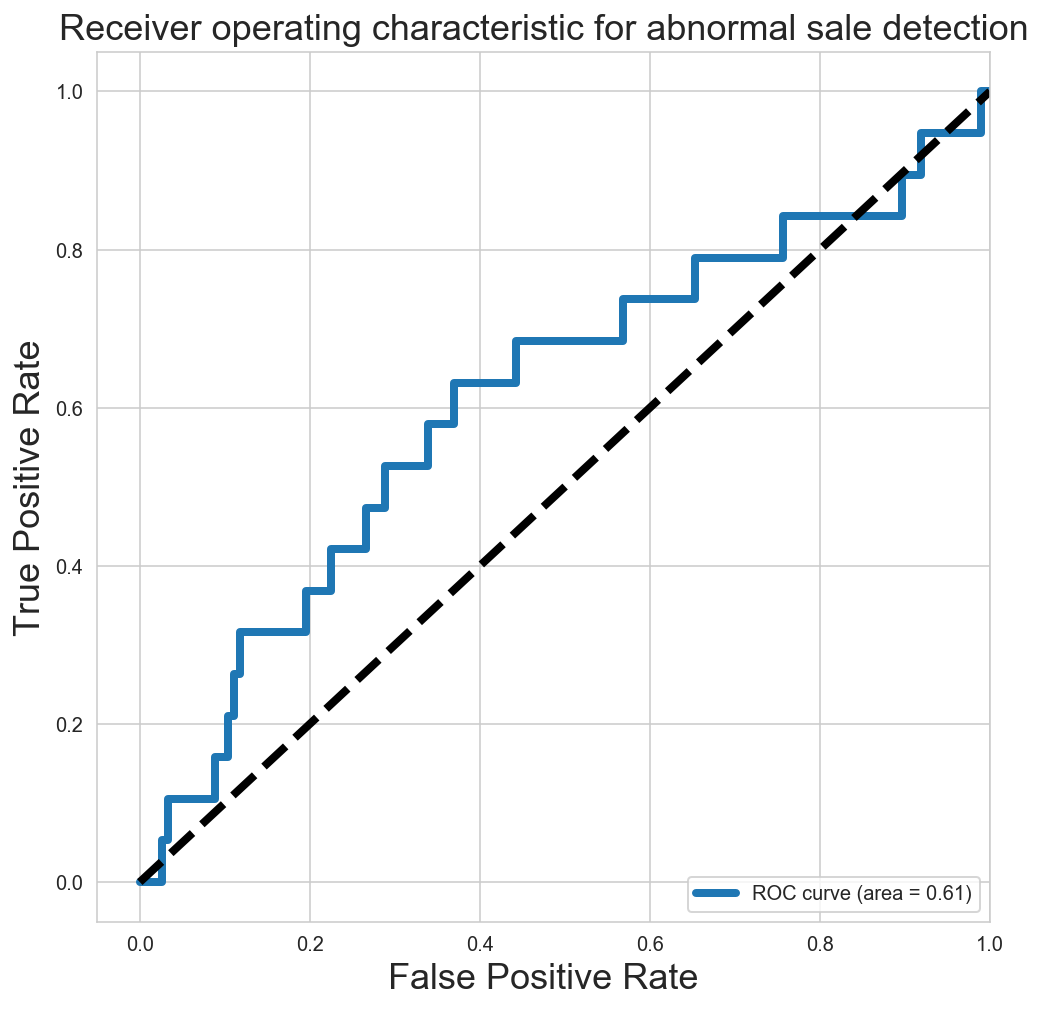

In [59]:
# For class 1, find the area under the curve.
fpr, tpr, _ = roc_curve(y3test, logreg_pp.class1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (abnormal sale).
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for abnormal sale detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

From the AUR-ROC, the area is about 0.61, which shows that our model is performing a little better than a random event.